# Screening Study

In this notebook we evaluate the effect of different types of layouts for screening experiments.

We begin by importing required packages.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt
import statistics
from scipy import stats
import ptitprince as pt
import os
import re
import csv 
from datetime import date
from statannotations.Annotator import Annotator
from sklearn import metrics

# Our libraries
import libraries.disturbances as dt
import libraries.normalization as nrm
import libraries.utilities as util
import libraries.screening as sc

## Data Generation

Here you can specify the details of the experiment.

We generated data based on [1], using layouts with 10 positive and 20 negative controls. 


In [220]:
## Simulation parameters
## Ensure that the appropriate PLAID layouts exist under compounds_PLAID_layouts 
pos_controls = 8
neg_controls = 8

id_text = "ROC-supplement"

#error = 0.125 #High
#error = 0.075 #Medium
#error = 0.025 #Low
#error = 0.0 #None

#NEW
#error = -0.075
error = 0.1
percent_non_active = 0.6

In [221]:
my_min_dist = 0

# Types of plate errors

#error_types = [{'type':"right-half", 'error_function':dt.add_errors_to_right_columns_half,'error_correction':nrm.normalize_plate_nearest_control}]
#error_types = [{'type':"diagonal", 'error_function':dt.add_diagonal_errors,'error_correction':nrm.normalize_plate_nearest_control}]
error_types = [{'type':"bowl-nl", 'error_function':dt.add_bowlshaped_errors_nl,'error_correction':nrm.normalize_plate_nearest_control}]
               #{'type':"left", 'error_function':dt.add_linear_errors_to_left_columns,'error_correction':nrm.normalize_plate_column_effect},
               #{'type':"right", 'error_function':dt.add_linear_errors_to_right_columns,'error_correction':nrm.normalize_plate_column_effect},
               #{'type':"top", 'error_function':dt.add_linear_errors_to_upper_rows,'error_correction':nrm.normalize_plate_row_effect},
               #{'type':"bottom", 'error_function':dt.add_linear_errors_to_lower_rows,'error_correction':nrm.normalize_plate_row_effect},
               #{'type':"left-exp", 'error_function':dt.add_exponential_errors_to_left_columns,'error_correction':nrm.normalize_plate_column_effect},
               #{'type':"top-exp", 'error_function':dt.add_exponential_errors_to_upper_rows,'error_correction':nrm.normalize_plate_row_effect},
               #{'type':"upper-half", 'error_function':dt.add_linear_errors_to_upper_rows_half,'error_correction':nrm.normalize_plate_row_effect},
               #{'type':"lower-half", 'error_function':dt.add_linear_errors_to_lower_rows_half,'error_correction':nrm.normalize_plate_row_effect},
               #{'type':"right-half", 'error_function':dt.add_linear_errors_to_right_columns_half,'error_correction':nrm.normalize_plate_column_effect}]



plate_types_location = [{'type':'PLAID','dir':'layouts/screening_PLAID_layouts/','regex':'plate_layout_'+str(neg_controls)+'-'+str(pos_controls)+'_(0*)(.+?).npy','error_correction':nrm.normalize_plate_lowess_2d},
                        {'type':'RANDOM','dir':'layouts/screening_manual_layouts/','regex':'plate_layout_rand_'+str(neg_controls)+'-'+str(pos_controls)+'_(0*)(.+?).npy','error_correction':nrm.normalize_plate_lowess_2d},
                       {'type':'BORDER','dir':'layouts/screening_manual_layouts/','regex':'plate_layout_border_'+str(neg_controls)+'-'+str(pos_controls)+'_(0*)(.+?).npy','error_correction':nrm.normalize_plate_linear}]

## Results
today = (date.today()).strftime("-%Y%m%d")+"-"+id_text

screening_scores_data_filename = 'screening_scores_data-'+str(pos_controls)+'-'+str(neg_controls)+'-'+str(error)+"-pna-"+str(percent_non_active)+today+'.csv'
residuals_filename = 'screening-residuals-'+str(pos_controls)+'-'+str(neg_controls)+'-'+str(error)+"-pna-"+str(percent_non_active)+today+'.csv'

screening_scores_data_f=open(screening_scores_data_filename,'a')

residuals_f=open(residuals_filename,'a')


Now we place them on a plate, add a small random noise, apply plate effects error and correct them.

In [218]:
neg_control_mean=100 #Keep at 100 to simplify calculations relative to percentage of negative control.
#pos_control_mean=40
neg_stdev=10
pos_stdev=10

In [222]:
# Write headers
scores_writer = csv.writer(screening_scores_data_f)
residuals_writer = csv.writer(residuals_f)

scores_writer.writerow(['batch','layout', 'error_type', 'error', 'lost_rows', 'neg_control_mean', 'pos_control_mean', 'neg_stdev', 'pos_stdev', 'Zfactor_expected', 'SSMD_expected', 'Zfactor_raw', 'SSMD_raw', 'Zfactor_norm', 'SSMD_norm'])
residuals_writer.writerow(['batch','layout', 'error_type', 'error', 'lost_rows', 'neg_control_mean', 'pos_control_mean', 'neg_stdev', 'pos_stdev', 'comp_id', 'true_residuals', 'expected_result','obtained_result', 'activity', 'plate_id'])

for batch in range(10):
    print("Running batch ",batch)
    for pos_control_mean in range(40,41,120):
        print("Testing pos_control_mean:",pos_control_mean)

        for plate_type in plate_types_location:
            print("Testing plates:",plate_type['type'])
            layout_dir = plate_type['dir']
            layouts = os.listdir(layout_dir)

            for layout_file in layouts:
                match = re.search(plate_type['regex'],layout_file)

                if match == None:
                    continue

                #print(layout_file)
                layout = np.load(layout_dir+layout_file)  

                neg_control_id = np.max(layout)
                pos_control_id = neg_control_id -1 

                for et in error_types:

                    for lost_rows in range(1,4): ##15
                    #for lost_rows in range(1,2): ##15
                        limits = [{'from':1, 'to':lost_rows}]
                        #limits = [{'from':16-lost_rows,'to':16}]
                        #limits = [{'from':1, 'to':lost_rows},{'from':16-lost_rows,'to':16}]
                        for limit in limits:  

                            # Fill in plate with "ideal" data
                            #ideal_plate = sc.fill_plate(layout,neg_control_mean,pos_control_mean,neg_stdev,pos_stdev)
                            ideal_plate, activity_layout = sc.fill_plate(layout, neg_control_id, pos_control_id, neg_control_mean, pos_control_mean, neg_stdev = neg_stdev, pos_stdev = pos_stdev, percent_non_active=percent_non_active)
                            #print(ideal_plate)

                            expected_neg_control_mean, expected_pos_control_mean, expected_neg_stdev, expected_pos_stdev = sc.control_stats(ideal_plate, layout, neg_control_id, pos_control_id)

                            ssmd_expected = sc.ssmd(expected_neg_control_mean, expected_pos_control_mean, expected_neg_stdev, expected_pos_stdev)
                            zfactor_expected = sc.zfactor(expected_neg_control_mean, expected_pos_control_mean, expected_neg_stdev, expected_pos_stdev)


                            # Apply disturbances
                            plate = et['error_function'](ideal_plate, error)
                            plate = dt.lose_rows(plate, limit['from'], limit['to'])

                            #print(plate)

                            # Get plate statistics before normalization
                            raw_neg_control_mean, raw_pos_control_mean, raw_neg_stdev, raw_pos_stdev = sc.control_stats(plate, layout, neg_control_id, pos_control_id)


                            ssmd_raw = sc.ssmd(raw_neg_control_mean, raw_pos_control_mean, raw_neg_stdev, raw_pos_stdev)
                            zfactor_raw = sc.zfactor(raw_neg_control_mean, raw_pos_control_mean, raw_neg_stdev, raw_pos_stdev)


                            # Apply normalization / error correction 
                            #control_locations = util.get_controls_layout(layout.astype(np.float32))
                            #control_locations = dt.lose_rows(control_locations, limit['from'], limit['to'])
                            #remaining_layout = dt.lose_rows(control_locations, limit['from'], limit['to'])

                            remaining_layout = dt.lose_rows(layout, limit['from'], limit['to'])

                            #plate = et['error_correction'](plate,control_locations,min_dist=my_min_dist)
                            plate = plate_type['error_correction'](plate,remaining_layout,neg_control_id = neg_control_id)


                            # Get plate statistics after normalization                                   
                            norm_neg_control_mean, norm_pos_control_mean, norm_neg_stdev, norm_pos_stdev = sc.control_stats(plate, remaining_layout, neg_control_id, pos_control_id)

                            ssmd_norm = sc.ssmd(norm_neg_control_mean, norm_pos_control_mean, norm_neg_stdev, norm_pos_stdev)
                            zfactor_norm = sc.zfactor(norm_neg_control_mean, norm_pos_control_mean, norm_neg_stdev, norm_pos_stdev)


                            ### Write to file!
                            scores_writer.writerow([batch,plate_type['type'], et['type'], error, lost_rows-1, expected_neg_control_mean, expected_pos_control_mean, expected_neg_stdev, expected_pos_stdev, zfactor_expected, ssmd_expected, zfactor_raw, ssmd_raw, zfactor_norm, ssmd_norm])

                            res_array = np.power(np.reshape(abs(np.subtract(dt.lose_rows(ideal_plate, limit['from'], limit['to']), plate)),(-1,1)),2)
                            comp_id_array = np.reshape(remaining_layout,(-1,1))
                            ideal_plate_array = np.reshape(ideal_plate,(-1,1))
                            norm_plate_array = np.reshape(plate,(-1,1))
                            activity_array = np.reshape(activity_layout,(-1,1)) ##NEW

                            comp_id_res_df = pd.DataFrame(np.hstack([comp_id_array,res_array,ideal_plate_array,norm_plate_array,activity_array]),columns = ['comp_type','res','expected_result','obtained_result','activity'])

                            comp_id_res_df = comp_id_res_df[comp_id_res_df.comp_type>0]

                            rrr = np.transpose(comp_id_res_df.to_numpy())
                            (_,res_size) = np.shape(rrr)

                            ###########
                            #plate_residuals = np.vstack([np.full(res_size,plate_type['type']), np.full(res_size,et['type']), np.full(res_size,error), np.full(res_size,lost_rows-1), np.full(res_size,expected_neg_control_mean), np.full(res_size,expected_pos_control_mean), np.full(res_size,expected_neg_stdev), np.full(res_size,expected_pos_stdev),res_array])
                            plate_residuals = np.vstack([np.full(res_size,batch),np.full(res_size,plate_type['type']), np.full(res_size,et['type']), np.full(res_size,error), np.full(res_size,lost_rows-1), np.full(res_size,expected_neg_control_mean), np.full(res_size,expected_pos_control_mean), np.full(res_size,expected_neg_stdev), np.full(res_size,expected_pos_stdev),rrr,np.full(res_size,match.group(2))])

                            np.savetxt(residuals_f, plate_residuals.T, delimiter=",",fmt='%s')



print("Done! :-)")

Running batch  0
Testing pos_control_mean: 40
Testing plates: PLAID
Testing plates: RANDOM
Testing plates: BORDER
Running batch  1
Testing pos_control_mean: 40
Testing plates: PLAID
Testing plates: RANDOM
Testing plates: BORDER
Running batch  2
Testing pos_control_mean: 40
Testing plates: PLAID
Testing plates: RANDOM
Testing plates: BORDER
Running batch  3
Testing pos_control_mean: 40
Testing plates: PLAID
Testing plates: RANDOM
Testing plates: BORDER
Running batch  4
Testing pos_control_mean: 40
Testing plates: PLAID
Testing plates: RANDOM
Testing plates: BORDER
Running batch  5
Testing pos_control_mean: 40
Testing plates: PLAID
Testing plates: RANDOM
Testing plates: BORDER
Running batch  6
Testing pos_control_mean: 40
Testing plates: PLAID
Testing plates: RANDOM
Testing plates: BORDER
Running batch  7
Testing pos_control_mean: 40
Testing plates: PLAID
Testing plates: RANDOM
Testing plates: BORDER
Running batch  8
Testing pos_control_mean: 40
Testing plates: PLAID
Testing plates: RAND

In [31]:
screening_scores_data_f.close()

residuals_f.close()

assert False

AssertionError: 

# Visual Examples

In [ ]:
from moepy import lowess, eda
from scipy.interpolate import interp1d

def plot_well_series_new(plate_array, layout, neg_control_id=-1, pos_control_id=-1,order=0,vmin=None,vmax=None,filename=None):
    
    normalized_plate = nrm.normalize_plate_lowess(plate_array,layout,min_dist=None)
    
    return normalized_plate

    
def plot_well_series_really(plate_array, layout, neg_control_id=-1, pos_control_id=-1,order=0,vmin=None,vmax=None,filename=None):
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.set(xlim=(0,25))
    
    ax = sns.regplot(data=combined_df[(combined_df.Type!=pos_control_id) & (combined_df.Type!=neg_control_id)], x="Columns", y="Intensity", x_jitter=0.3, fit_reg=False, scatter_kws={"color":"orange","alpha":0.3})
    
    ax = sns.regplot(data=combined_df[combined_df.Type==pos_control_id], x="Columns", y="Intensity", x_jitter=0.3, fit_reg=False, marker="+",scatter_kws={"color":"blue"})
    
    ax = sns.regplot(data=combined_df[combined_df.Type==neg_control_id], x="Columns", y="Intensity", x_jitter=0.3, fit_reg=False, marker='*',scatter_kws={"color":"purple"}, truncate=False, order=order)
    
    #ax = sns.regplot(data=temp, x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, marker='*',scatter_kws={"color":"red"}, truncate=False, order=order)
    
    ax = sns.regplot(data=y_adjusted, x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, marker='x',scatter_kws={"color":"blue"}, truncate=False, order=order)
    
    #ax = sns.regplot(data=y_adjusted, x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, marker='x',scatter_kws={"color":"blue"}, truncate=False, order=order)
    
    plt.plot(xnew, y_pred, '--', label='Estimate', color='k', zorder=3)
    
    ax.set_xticks(range(1,25))
    
    plt.show()
    
    if (filename):
        fig.savefig(filename)
    
    
def plot_well_series(plate_array, layout, neg_control_id=-1, pos_control_id=-1,order=0,vmin=None,vmax=None,filename=None):
    
    #intensity_df = np.log2(plate_df).stack().reset_index()
    #intensity_df = np.log10(plate_df).stack().reset_index()
    
    #util.plot_plate(plate_df, title="Input again")
    
    plate_df = pd.DataFrame(plate_array)
    
    intensity_df = plate_df.stack().reset_index() ##
    intensity_df.columns = ["Rows","Columns","Intensity"] ##
    
    types_df = pd.DataFrame(layout).stack().reset_index() ##
    types_df.columns = ["Rows","Columns","Type"] ##
    
    combined_df = pd.merge(intensity_df, types_df,  how='left', on=['Rows','Columns']) ##
    
    #combined_df = combined_df[combined_df.Type!=0]

    #combined_df['Rows'] += 1
    #combined_df['Columns'] += 1
    
    
    #### Test unstack
    
    unstack_df = combined_df[["Rows","Columns","Intensity"]].copy()
    #unstack_df['Rows'] -= 1
    #unstack_df['Columns'] -= 1
    
    unstacked_df = pd.pivot_table(unstack_df, values='Intensity', index=['Rows'],columns=['Columns'], aggfunc=np.sum)
    
    util.plot_plate(unstacked_df, title="Input",filename=filename+'heatmap-before')
    
    ####
    
    #fig, ax = plt.subplots(figsize=(10,6))
    #ax = sns.scatterplot(data=intensity_df, x="Columns", y="Intensity")

    ## Regression
    
    #reg_res = lowess(combined_df[combined_df.Type==neg_control_id].Intensity, combined_df[combined_df.Type==neg_control_id].Columns, it=1000)
    
    ## Before ###
    
    y_adjusted = combined_df.copy()
    y_adjusted.reset_index() ##
    
    
    ## CALL NORM
    
    ### Adjust rows
    lowess_rows_model = lowess.Lowess()
    lowess_rows_model.fit(y_adjusted[y_adjusted.Type==neg_control_id].Rows.to_numpy(),y_adjusted[y_adjusted.Type==neg_control_id].Intensity.to_numpy(),frac=1,num_fits=5000)

    xnew_rows = np.array([i for i in range(0,16)])
    y_pred_rows = lowess_rows_model.predict(xnew_rows)
    
    y_adjusted.loc[y_adjusted['Type']>0, ['Intensity']] -= y_pred_rows[y_adjusted.loc[y_adjusted['Type']>0,['Rows']]] 
    y_adjusted.loc[y_adjusted['Type']>0, ['Intensity']] += np.nanmean(y_pred_rows)
    
    # Model fitting Columns
    lowess_model = lowess.Lowess()
##    lowess_model.fit(combined_df[combined_df.Type==neg_control_id].Columns.to_numpy(),combined_df[combined_df.Type==neg_control_id].Intensity.to_numpy(),frac=1,num_fits=5000)
    lowess_model.fit(y_adjusted[y_adjusted.Type==neg_control_id].Columns.to_numpy(),y_adjusted[y_adjusted.Type==neg_control_id].Intensity.to_numpy(),frac=1,num_fits=5000)

    xnew = np.array([i for i in range(0,24)])

    #x_pred = np.linspace(0, 5, 26)
    y_pred = lowess_model.predict(xnew)

    
    y_adjusted.loc[y_adjusted['Type']>0, ['Intensity']] -= y_pred[y_adjusted.loc[y_adjusted['Type']>0,['Columns']]] 
    y_adjusted.loc[y_adjusted['Type']>0, ['Intensity']] += np.nanmean(y_pred)
    
    
    
    #Yraw - Ypredicted + mean(Ypredicted)
    
    #print(ynew[combined_df.Columns])
    
    #print(y_adjusted.Intensity)
    #print(combined_df[combined_df.Type==neg_control_id].Intensity.reset_index() )
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.set(xlim=(0,25))
    
    ax = sns.regplot(data=combined_df[(combined_df.Type!=pos_control_id) & (combined_df.Type!=neg_control_id)], x="Columns", y="Intensity", x_jitter=0.3, fit_reg=False, scatter_kws={"color":"orange","alpha":0.3})
    
    ax = sns.regplot(data=combined_df[combined_df.Type==pos_control_id], x="Columns", y="Intensity", x_jitter=0.3, fit_reg=False, marker="+",scatter_kws={"color":"blue"})
    
    ax = sns.regplot(data=combined_df[combined_df.Type==neg_control_id], x="Columns", y="Intensity", x_jitter=0.3, fit_reg=False, marker='*',scatter_kws={"color":"purple"}, truncate=False, order=order)
    
    #ax = sns.regplot(data=temp, x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, marker='*',scatter_kws={"color":"red"}, truncate=False, order=order)
    
    ax = sns.regplot(data=y_adjusted, x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, marker='x',scatter_kws={"color":"blue"}, truncate=False, order=order)
    
    #ax = sns.regplot(data=y_adjusted, x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, marker='x',scatter_kws={"color":"blue"}, truncate=False, order=order)
    
    plt.plot(xnew, y_pred, '--', label='Estimate', color='k', zorder=3)
    
    ax.set_xticks(range(1,25))
    
    plt.show()
    
    if (filename):
        fig.savefig(filename)
        
    unstack_adjusted_df = y_adjusted[["Rows","Columns","Intensity"]].copy()
    #unstack_adjusted_df['Rows'] -= 1
    #unstack_adjusted_df['Columns'] -= 1
    
    unstacked_adjusted_df = pd.pivot_table(unstack_adjusted_df, values='Intensity', index=['Rows'],columns=['Columns'], aggfunc=np.sum)
    
    #util.plot_plate(unstacked_adjusted_df, title="Normalized",vmin=vmin,vmax=vmax,filename=filename+'heatmap-after')
    
    return unstacked_adjusted_df.to_numpy()


In [ ]:
#from moepy import lowess, eda


def plot_well_series_border(plate_array, layout, neg_control_id=-1, pos_control_id=-1,order=0,vmin=None,vmax=None,filename=None):
    
    normalized_plate = normalize_plate_linear(plate_array,layout)
    
    return normalized_plate




def plot_well_series_border_old(plate_df, layout, neg_control_id=-1, pos_control_id=-1,order=0,vmin=None,vmax=None,filename=None):
    
    intensity_df = plate_df.stack().reset_index()
    intensity_df.columns = ["Rows","Columns","Intensity"]
    
    types_df = pd.DataFrame(layout).stack().reset_index()
    types_df.columns = ["Rows","Columns","Type"]
    
    combined_df = pd.merge(intensity_df, types_df,  how='left', on=['Rows','Columns'])
    
    combined_df = combined_df[combined_df.Type!=0]

    combined_df['Rows'] += 1
    combined_df['Columns'] += 1
    
    
    #### Test unstack
    
    unstack_df = combined_df[["Rows","Columns","Intensity"]].copy()
    unstack_df['Rows'] -= 1
    unstack_df['Columns'] -= 1
    
    unstacked_df = pd.pivot_table(unstack_df, values='Intensity', index=['Rows'],columns=['Columns'], aggfunc=np.sum)
    
    util.plot_plate(unstacked_df, title="Input",filename=filename+'heatmap-before')
    
    ####
    
    #fig, ax = plt.subplots(figsize=(10,6))
    #ax = sns.scatterplot(data=intensity_df, x="Columns", y="Intensity")

    ## Regression
    
    #reg_res = lowess(combined_df[combined_df.Type==neg_control_id].Intensity, combined_df[combined_df.Type==neg_control_id].Columns, it=1000)
    
    ## Before Adjusting ###
    
    y_adjusted = combined_df.copy()
    y_adjusted.reset_index()
    
    ### Adjust rows & columns (weird results)
    #linear_model_rows = LinearRegression()
    #linear_model_rows.fit(y_adjusted[y_adjusted.Type==neg_control_id][['Columns','Rows']].to_numpy(),y_adjusted[y_adjusted.Type==neg_control_id].Intensity.to_numpy().reshape(-1, 1))

    #xnew_rows = np.array([i for i in range(0,16)])
    #y_pred_rows = linear_model_rows.predict(y_adjusted[['Columns','Rows']])
    #mean_y = np.nanmean(y_pred_rows)
    #print(y_pred_rows)
    
    #for i in y_adjusted.index:
     #   y_adjusted.at[i, "Intensity"] -= linear_model_rows.predict([[y_adjusted.at[i,'Rows'],y_adjusted.at[i,'Columns']]])
      #  y_adjusted.at[i, "Intensity"] += mean_y
    
    ###################
    
    ### Adjust rows
    linear_model_rows = LinearRegression()
    linear_model_rows.fit(y_adjusted[y_adjusted.Type==neg_control_id].Rows.to_numpy().reshape(-1,1),y_adjusted[y_adjusted.Type==neg_control_id].Intensity.to_numpy().reshape(-1, 1))

    xnew_rows = np.array([i for i in range(0,16)])
    y_pred_rows = linear_model_rows.predict(xnew_rows.reshape(-1, 1))
    mean_y = np.nanmean(y_pred_rows)
    #print(y_pred_rows)
    
    #print(y_adjusted)
    #y_adjusted.Intensity -= y_pred_rows[y_adjusted.Rows]  #+ np.mean(ynew)
    #y_adjusted.Intensity = y_adjusted.Intensity + np.nanmean(y_pred_rows)
     
    for i in y_adjusted.index:
        y_adjusted.at[i, "Intensity"] -= linear_model_rows.predict([[y_adjusted.at[i,'Rows']]])
        y_adjusted.at[i, "Intensity"] += mean_y
    
    
    ### Adjust columns
    linear_model_columns = LinearRegression()
    linear_model_columns.fit(y_adjusted[y_adjusted.Type==neg_control_id].Columns.to_numpy().reshape(-1,1),y_adjusted[y_adjusted.Type==neg_control_id].Intensity.to_numpy().reshape(-1, 1))

    xnew_columns = np.array([i for i in range(0,25)])
    y_pred_columns = linear_model_columns.predict(xnew_columns.reshape(-1, 1))
    mean_y = np.nanmean(y_pred_columns)
    #print(y_pred_rows)
    
    #print(y_adjusted)
    #y_adjusted.Intensity -= y_pred_rows[y_adjusted.Rows]  #+ np.mean(ynew)
    #y_adjusted.Intensity = y_adjusted.Intensity + np.nanmean(y_pred_rows)
     
    for i in y_adjusted.index:
        y_adjusted.at[i, "Intensity"] -= linear_model_columns.predict([[y_adjusted.at[i,'Columns']]])
        y_adjusted.at[i, "Intensity"] += mean_y
    
    
    
    
    
    #y_adjusted.Intensity -= linear_model_rows.predict(y_adjusted[['Columns','Rows']])  #+ np.mean(ynew)
    #y_adjusted.Intensity += 
    
    
    
    # Model fitting Columns
#    linear_model_columns = LinearRegression()
 #   linear_model_columns.fit(combined_df[combined_df.Type==neg_control_id,['Columns','Rows']],combined_df[combined_df.Type==neg_control_id].Intensity.to_numpy().reshape(-1, 1))

  #  xnew = np.array([i for i in range(0,25)])

    #x_pred = np.linspace(0, 5, 26)
   # y_pred = linear_model_columns.predict(xnew)

    
#    y_adjusted.Intensity =  (combined_df[combined_df.Type==neg_control_id]).reset_index().Intensity - y_adjusted.Intensity  + np.mean(y_adjusted.Intensity)
    #y_adjusted.Intensity -= y_pred[y_adjusted.Columns]  #+ np.mean(ynew)
   # y_adjusted.Intensity = y_adjusted.Intensity + np.nanmean(y_pred)
    
    
    
    #Yraw - Ypredicted + mean(Ypredicted)
    
    #print(ynew[combined_df.Columns])
    
    #print(y_adjusted.Intensity)
    #print(combined_df[combined_df.Type==neg_control_id].Intensity.reset_index() )
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.set(xlim=(0,25))
    
    ax = sns.regplot(data=combined_df[(combined_df.Type!=pos_control_id) & (combined_df.Type!=neg_control_id)], x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, scatter_kws={"color":"orange","alpha":0.3})
    
    ax = sns.regplot(data=combined_df[combined_df.Type==pos_control_id], x="Columns", y="Intensity", x_jitter=0.3, fit_reg=False, marker="+",scatter_kws={"color":"blue"})
    
    ax = sns.regplot(data=combined_df[combined_df.Type==neg_control_id], x="Columns", y="Intensity", x_jitter=0.3, fit_reg=False, marker='*',scatter_kws={"color":"purple"}, truncate=False, order=order)
    
    #ax = sns.regplot(data=temp, x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, marker='*',scatter_kws={"color":"red"}, truncate=False, order=order)
    
    ax = sns.regplot(data=y_adjusted, x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, marker='x',scatter_kws={"color":"blue"}, truncate=False, order=order)
    
    #ax = sns.regplot(data=y_adjusted, x="Columns", y="Intensity", x_jitter=0.3, fit_reg=True, marker='x',scatter_kws={"color":"blue"}, truncate=False, order=order)
    
    #plt.plot(xnew, y_pred, '--', label='Estimate', color='k', zorder=3)
    
    ax.set_xticks(range(1,25))
    
    plt.show()
    
    if (filename):
        fig.savefig(filename)
        
    unstack_adjusted_df = y_adjusted[["Rows","Columns","Intensity"]].copy()
    unstack_adjusted_df['Rows'] -= 1
    unstack_adjusted_df['Columns'] -= 1
    
    unstacked_adjusted_df = pd.pivot_table(unstack_adjusted_df, values='Intensity', index=['Rows'],columns=['Columns'], aggfunc=np.sum)
    
    util.plot_plate(unstacked_adjusted_df, title="Normalized",filename=filename+'heatmap-after')


In [ ]:
layout_dir = 'screening_manual_layouts/'
layout_file = 'plate_layout_border_20-10_01.npy'

#layout_dir = 'compounds_manual_layouts/'
#layout_file = 'plate_layout_border_01.npy'

layout = np.load(layout_dir+layout_file)  
            
neg_control_id = np.max(layout)
pos_control_id = neg_control_id -1 
#pos_control_id = -1 

neg_control_mean = 90
pos_control_mean = 60
neg_stdev = 2
pos_stdev = 7

ideal_plate = sc.fill_plate(layout,neg_control_id,pos_control_id,neg_control_mean,pos_control_mean,neg_stdev,pos_stdev)
#plate_df = pd.DataFrame(ideal_plate)
#plate_df = pd.DataFrame(sc.fill_plate(layout,neg_control_mean,pos_control_mean,neg_stdev,pos_stdev))

#plate_df.head()
util.plot_plate(pd.DataFrame(ideal_plate), title="Ideal Plate")

norm_plate = plot_well_series_border(ideal_plate,layout,neg_control_id,pos_control_id,filename="border-no-error")

util.plot_plate(pd.DataFrame(norm_plate), title="Normalized Ideal Plate")
##

disturbed_plate = dt.add_linear_errors_to_right_columns(ideal_plate, 1.25)
util.plot_plate(pd.DataFrame(disturbed_plate), title="Linear Column Errors")

norm_plate = plot_well_series_border(disturbed_plate,layout,neg_control_id,pos_control_id,filename='border-linear-right')

util.plot_plate(pd.DataFrame(norm_plate), title="Normalized linear column errors Plate")



disturbed_plate = dt.add_linear_errors_to_right_columns_half(ideal_plate, 2)
util.plot_plate(pd.DataFrame(disturbed_plate), title="Linear Half Column Errors")

norm_plate = plot_well_series_border(disturbed_plate,layout,neg_control_id,pos_control_id,filename='border-linear-right-half')

util.plot_plate(pd.DataFrame(norm_plate), title="Normalized half linear column errors Plate")


disturbed_plate = dt.add_linear_errors_to_lower_rows(ideal_plate, 0.025)
util.plot_plate(pd.DataFrame(disturbed_plate), title="Linear Rows Errors")

norm_plate = plot_well_series_border(disturbed_plate,layout,neg_control_id,pos_control_id,filename='border-linear-rows')

util.plot_plate(pd.DataFrame(norm_plate), title="Normalized Rows error Plate")


disturbed_plate = dt.add_bowlshaped_errors(ideal_plate, 0.05)
util.plot_plate(pd.DataFrame(disturbed_plate), title="Bowl Errors")

norm_plate1 = plot_well_series_border(disturbed_plate,layout,neg_control_id,pos_control_id,filename='border-bowlshape')

util.plot_plate(pd.DataFrame(norm_plate1), title="Normalized Bowl Error Plate")

In [ ]:
layout_dir = 'screening_manual_layouts/'
layout_file = 'plate_layout_rand_20-10_02.npy'

#layout_dir = 'compounds_manual_layouts/'
#layout_file = 'plate_layout_border_01.npy'

layout = np.load(layout_dir+layout_file)  
            
neg_control_id = np.max(layout)
pos_control_id = neg_control_id -1 
#pos_control_id = -1 

neg_control_mean = 90
pos_control_mean = 60
neg_stdev = 2
pos_stdev = 7

np.random.seed(42)

ideal_plate = sc.fill_plate(layout,neg_control_id,pos_control_id,neg_control_mean,pos_control_mean,neg_stdev,pos_stdev)
#plate_df = pd.DataFrame(ideal_plate)
#plate_df = pd.DataFrame(sc.fill_plate(layout,neg_control_mean,pos_control_mean,neg_stdev,pos_stdev))

util.plot_plate(pd.DataFrame(ideal_plate), title="Ideal Plate")


np.random.seed(42)
norm_plate = plot_well_series(ideal_plate,layout,neg_control_id,pos_control_id,order=1,filename='random-none')

util.plot_plate(pd.DataFrame(norm_plate), title="Normalized Ideal Plate")

##

np.random.seed(42)
disturbed_plate = dt.add_linear_errors_to_upper_rows_half(ideal_plate, 4)
util.plot_plate(pd.DataFrame(disturbed_plate), title="add_exponential_errors_to_upper_rows")

np.random.seed(42)
norm_plate = plot_well_series(disturbed_plate,layout,neg_control_id,pos_control_id,order=2,vmin=None,vmax=None,filename='test')
util.plot_plate(pd.DataFrame(norm_plate), title="Normalized after add_exponential_errors_to_upper_rows")


###
np.random.seed(42)
disturbed_plate = dt.add_linear_errors_to_right_columns(ideal_plate, 2)

util.plot_plate(pd.DataFrame(disturbed_plate), title="Linear Column Errors")

np.random.seed(42)
norm_plate = plot_well_series(disturbed_plate,layout,neg_control_id,pos_control_id,order=1,filename='random-columns')

util.plot_plate(pd.DataFrame(norm_plate), title="Normalized after Linear Column Errors")


np.random.seed(42)
disturbed_plate = dt.add_linear_errors_to_right_columns_half(ideal_plate, 2)
util.plot_plate(pd.DataFrame(disturbed_plate), title="Half Linear Column Errors")
np.random.seed(42)
norm_plate = plot_well_series(disturbed_plate,layout,neg_control_id,pos_control_id,order=1,filename='random-columns-half')

util.plot_plate(pd.DataFrame(norm_plate), title="Normalized after Half Linear Column Errors")

np.random.seed(42)
disturbed_plate = dt.add_linear_errors_to_lower_rows(ideal_plate, 2)
util.plot_plate(pd.DataFrame(disturbed_plate), title="Linear Rows Errors")
np.random.seed(42)
norm_plate = plot_well_series(disturbed_plate,layout,neg_control_id,pos_control_id,filename='random-rows')

control_locations=util.get_controls_layout(layout)

util.plot_plate(pd.DataFrame(norm_plate), title="Normalized after Linear Rows Errors")

np.random.seed(42)
disturbed_plate = dt.add_bowlshaped_errors(ideal_plate, 2)
util.plot_plate(pd.DataFrame(disturbed_plate), title="Bowl-Shaped Errors")

np.random.seed(42)
norm_plate = plot_well_series(disturbed_plate,layout,neg_control_id,pos_control_id,order=2,vmin=None,vmax=None,filename='random-bowlshape')
util.plot_plate(pd.DataFrame(norm_plate), title="Normalized after Bowl-Shaped Errors")

control_locations=util.get_controls_layout(layout)
util.plot_plate(disturbed_plate, title="", mask=np.array(1-control_locations,dtype=bool), filename = "plaid-controls-rows-error.png")

###



In [ ]:
layout_dir = 'screening_PLAID_layouts/'
layout_file = 'plate_layout_20-10_01.npy'

#layout_dir = 'compounds_manual_layouts/'
#layout_file = 'plate_layout_border_01.npy'

layout = np.load(layout_dir+layout_file)  
            
neg_control_id = np.max(layout)
pos_control_id = neg_control_id -1 

neg_control_mean = 90
pos_control_mean = 60
neg_stdev = 2
pos_stdev = 7

np.random.seed(42)

ideal_plate = sc.fill_plate(layout,neg_control_id,pos_control_id,neg_control_mean,pos_control_mean,neg_stdev,pos_stdev)
plate_df = pd.DataFrame(ideal_plate)
#plate_df = pd.DataFrame(sc.fill_plate(layout,neg_control_mean,pos_control_mean,neg_stdev,pos_stdev))

plate_df.head()
np.random.seed(42)
plot_well_series(plate_df,layout,neg_control_id,pos_control_id,filename='PLAID-none')

##
np.random.seed(42)
disturbed_plate = dt.add_linear_errors_to_right_columns(ideal_plate, 1.5)
np.random.seed(42)
plot_well_series(pd.DataFrame(disturbed_plate),layout,neg_control_id,pos_control_id,filename='PLAID-columns-error')

np.random.seed(42)
disturbed_plate = dt.add_linear_errors_to_right_columns_half(ideal_plate, 2)
np.random.seed(42)
plot_well_series(pd.DataFrame(disturbed_plate),layout,neg_control_id,pos_control_id,filename='PLAID-columns-error-half')


np.random.seed(42)
disturbed_plate = dt.add_linear_errors_to_lower_rows(ideal_plate, 0.05)
np.random.seed(42)
plot_well_series(pd.DataFrame(disturbed_plate),layout,neg_control_id,pos_control_id,filename='PLAID-rows-error')

control_locations=util.get_controls_layout(layout)
util.plot_plate(disturbed_plate, title="", mask=np.array(1-control_locations,dtype=bool), filename = "plaid-controls-rows-error.png")



np.random.seed(42)
disturbed_plate = dt.add_bowlshaped_errors(ideal_plate, 0.05)
np.random.seed(42)
plot_well_series(pd.DataFrame(disturbed_plate),layout,neg_control_id,pos_control_id,order=2,filename='PLAID-bowlshape',vmin=None,vmax=None)

In [ ]:
sns.regplot(data=temp_df, x="Columns", y="Intensity", x_jitter=0.3)

In [ ]:
## Example of how to use lowess normalization
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
lowess([0] * 10 + [1] * 10, range(3,23), it=50)

## Evaluating Plate Scores

We plot the plate scores obtained for all the plates using a PLAID layout versus a completly random layout.

In [ ]:
## Loading data

# Modify this line if you want to load an older file
# or comment it out if you want to use the file just written
#screening_scores_data_filename = 'screening_scores_data-10-10-0.125-20210930.csv'
#screening_scores_data_filename = 'screening_scores_data-10-20-0.085-20220307.csv'

screening_scores_data_filename = 'screening_scores_data-10-20-0.05-20220323-test.csv' ## Paper?
#screening_scores_data_filename = 'screening_scores_data-10-20-0.05-20220323-lose-rows.csv'
screening_scores_data_filename = 'screening_scores_data-10-10-0.1-20220428-mean-36.csv' # Nice ROC
screening_scores_df = pd.read_csv(screening_scores_data_filename)

print(screening_scores_df.head())

#screening_scores_df = screening_scores_df[screening_scores_df['lost_rows']<1]

#screening_scores_df = screening_scores_df[screening_scores_df['pos_control_mean']>30]

#screening_scores_df = screening_scores_df[screening_scores_df['pos_control_mean']<40]

#screening_scores_df = screening_scores_df[(screening_scores_df['error_type']=='bowl') | (screening_scores_df['error_type']=='left') | (screening_scores_df['error_type']=='top')| (screening_scores_df['error_type']=='left-exp')]

screening_scores_df['Zfactor_expected'] = pd.to_numeric(screening_scores_df['Zfactor_expected'], errors='coerce')
screening_scores_df['Zfactor_norm'] = pd.to_numeric(screening_scores_df['Zfactor_norm'], errors='coerce')
screening_scores_df['Zfactor_raw'] = pd.to_numeric(screening_scores_df['Zfactor_raw'], errors='coerce')

screening_scores_df['SSMD_expected'] = pd.to_numeric(screening_scores_df['SSMD_expected'], errors='coerce')
screening_scores_df['SSMD_norm'] = pd.to_numeric(screening_scores_df['SSMD_norm'], errors='coerce')
screening_scores_df['SSMD_raw'] = pd.to_numeric(screening_scores_df['SSMD_raw'], errors='coerce')

screening_scores_df['Zfactor_diff'] = (screening_scores_df['Zfactor_expected'] - screening_scores_df['Zfactor_norm'])**2

#screening_scores_df['SSMD_diff'] = np.abs(np.log10(np.abs(screening_scores_df['SSMD_expected'])) - np.log10(np.abs(screening_scores_df['SSMD_norm'])))
screening_scores_df['SSMD_diff'] = (screening_scores_df['SSMD_expected'] - screening_scores_df['SSMD_norm'])**2

screening_scores_df['Zfactor_diff_large'] = (screening_scores_df['Zfactor_expected'] - screening_scores_df['Zfactor_raw'])**2

screening_scores_df['SSMD_diff_large'] = (screening_scores_df['SSMD_expected'] - screening_scores_df['SSMD_raw'])**2

screening_scores_df['SSMD_diff_2'] = (screening_scores_df['SSMD_norm'] - screening_scores_df['SSMD_raw'])**2

screening_scores_df['SSMD_abs'] = np.abs(screening_scores_df['SSMD_raw'])

screening_scores_df['SSMD_norm_abs'] = np.abs(screening_scores_df['SSMD_norm'])



In [ ]:
### This is only needed when the specific layout name is stored in 'layout' ###

screening_scores_df.loc[(screening_scores_df['layout'] >= "plate_layout_rand"), 'layout'] = "RANDOM"
screening_scores_df.loc[(screening_scores_df['layout'] >= "plate_layout_border") & (screening_scores_df['layout'] != "RANDOM"), 'layout'] = "BORDER"
screening_scores_df.loc[(screening_scores_df['layout'] >= "plate_layout") & (screening_scores_df['layout'] != "RANDOM") & (screening_scores_df['layout'] != "BORDER"), 'layout'] = "PLAID"


In [ ]:
print('Summary of statistics for PLAID layouts:')
print(screening_scores_df[screening_scores_df['layout']=='PLAID'].describe(),"\n")

print('Summary of statistics for RANDOM layouts:')
print(screening_scores_df[screening_scores_df['layout']=='RANDOM'].describe(),"\n")

print('Summary of statistics for BORDER layouts:')
print(screening_scores_df[screening_scores_df['layout']=='BORDER'].describe(),"\n")


In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))
#ax.set(ylim=(-0.2,0.6))
#ax.set(xlabel='Residuals', ylabel='Layout type')
ax = sns.barplot(x='layout', y="Zfactor_raw", data=screening_scores_df, palette='rocket_r')

pvalue_thresholds = [[1e-64, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]

#test_results = statannot.add_stat_annotation(ax, data=screening_scores_df, x='layout', y="Zfactor_raw", order=["PLAID","RANDOM","BORDER"],
#                                   box_pairs=[("PLAID", "RANDOM"), ("RANDOM", "BORDER"), ("PLAID", "BORDER")],
#                                   test='t-test_ind', text_format='star',#line_offset_to_box=-0.3, pvalue_thresholds = pvalue_thresholds,
#                                   loc='inside', verbose=2, plot='barplot')
#test_results
pairs = [("PLAID", "RANDOM"), ("RANDOM", "BORDER"), ("PLAID", "BORDER")]
annotator = Annotator(ax, pairs=pairs, data=screening_scores_df, x='layout', y="Zfactor_raw", order=["PLAID","RANDOM","BORDER"])
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.show()

In [ ]:
## Moved to utilities

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))
#ax.set(ylim=(0,0.6))
#ax.set(xlabel='Residuals', ylabel='Layout type')
ax = sns.barplot(x='layout', y="Zfactor_norm", data=screening_scores_df, palette='rocket_r')
plt.show()

In [ ]:
fig.savefig("screening-zfactor.png",bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))
#ax.set(ylim=(0,16.5))
ax = sns.barplot(x='layout', y="SSMD_abs", data=screening_scores_df, palette='rocket_r')
ax.set(xlabel='', ylabel='SSMD')
plt.show()
fig.savefig("screening-ssmd-raw.png",bbox_inches='tight')

In [ ]:
# Moved to utilities

In [ ]:
fig.savefig("screening-ssmd-bowl-0.05.png",bbox_inches='tight',dpi=1200)

In [ ]:
rand_results_array = screening_scores_df.Zfactor_norm[screening_scores_df['layout']=='RANDOM']
plaid_results_array = screening_scores_df.Zfactor_norm[screening_scores_df['layout']=='PLAID']
border_results_array = screening_scores_df.Zfactor_norm[screening_scores_df['layout']=='BORDER']

print("Variance of PLAID layouts:", statistics.variance(plaid_results_array))
print("Variance of RANDOM layouts:", statistics.variance(rand_results_array))
print("Variance of BORDER layouts:", statistics.variance(border_results_array))

print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array))
print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False))

In [ ]:
rand_results_array = screening_scores_df.Zfactor_raw[screening_scores_df['layout']=='RANDOM']
plaid_results_array = screening_scores_df.Zfactor_raw[screening_scores_df['layout']=='PLAID']
border_results_array = screening_scores_df.Zfactor_raw[screening_scores_df['layout']=='BORDER']

print("Variance of PLAID layouts:", statistics.variance(plaid_results_array))
print("Variance of RANDOM layouts:", statistics.variance(rand_results_array))
print("Variance of BORDER layouts:", statistics.variance(border_results_array))

print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array))
print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False))

In [ ]:
rand_results_array = screening_scores_df.SSMD_norm[screening_scores_df['layout']=='RANDOM']
plaid_results_array = screening_scores_df.SSMD_norm[screening_scores_df['layout']=='PLAID']
border_results_array = screening_scores_df.SSMD_norm[screening_scores_df['layout']=='BORDER']

print("Variance of PLAID layouts:", statistics.variance(plaid_results_array))
print("Variance of RANDOM layouts:", statistics.variance(rand_results_array))
print("Variance of BORDER layouts:", statistics.variance(border_results_array))

print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array))
print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False))

In [ ]:
rand_results_array = screening_scores_df.SSMD_raw[screening_scores_df['layout']=='RANDOM']
plaid_results_array = screening_scores_df.SSMD_raw[screening_scores_df['layout']=='PLAID']
border_results_array = screening_scores_df.SSMD_raw[screening_scores_df['layout']=='BORDER']

print("Variance of PLAID layouts:", statistics.variance(plaid_results_array))
print("Variance of RANDOM layouts:", statistics.variance(rand_results_array))
print("Variance of BORDER layouts:", statistics.variance(border_results_array))

print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array))
print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
#ax.set(ylim=(0,0.6))
ax.set(xlabel='Residuals', ylabel='Layout type')
ax = sns.barplot(x='layout', y="Zfactor_diff", data=screening_scores_df, palette='rocket_r', order=["PLAID","RANDOM"])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
#ax.set(ylim=(0,0.6))
ax.set(xlabel='Residuals', ylabel='Layout type')
ax = sns.barplot(x='layout', y="SSMD_diff", data=screening_scores_df, palette='rocket_r')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
#ax.set(ylim=(0,0.6))
ax.set(xlabel='Residuals', ylabel='Layout type')
ax = sns.barplot(x='layout', y="SSMD_abs", data=screening_scores_df, palette='rocket_r')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
#ax.set(ylim=(0,0.6))
#ax.set(xlabel='Residuals', ylabel='Layout type')
ax = sns.barplot(x='layout', y="SSMD_norm", data=screening_scores_df, palette='rocket_r')
plt.show()

# Paper plots

In [ ]:
screening_scores_data_filename = 'screening_scores_data-10-10-0.04-20220324-10-10.csv'
fig_name = "bowl-10-10-0.04-stdev-10"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.0)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=10.0)

In [ ]:
## KEEP???
screening_scores_data_filename = 'screening_scores_data-10-10-0.1-pna-0.99-20220920-stdev-5.csv'
fig_name = "bowl-10-10-0.1-stdev-5"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

In [ ]:
## KEEP???
screening_scores_data_filename = 'screening_scores_data-10-10-0.075-pna-0.99-20220920-stdev-5.csv'
fig_name = "bowl-10-10-0.075-stdev-5"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

In [ ]:
## KEEP???
screening_scores_data_filename = 'screening_scores_data-10-10-0.07-pna-0.99-20220920-stdev-5.csv'
fig_name = "bowl-10-10-0.07-stdev-5"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

In [ ]:
## KEEP???
screening_scores_data_filename = 'screening_scores_data-10-10-0.06-pna-0.99-20220920-stdev-5.csv'
fig_name = "bowl-10-10-0.06-stdev-5"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

In [ ]:
## KEEP???
screening_scores_data_filename = 'screening_scores_data-10-10-0.05-pna-0.99-20220920-stdev-5.csv'
fig_name = "bowl-10-10-0.05-stdev-5"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.0-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.0-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.01-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.01-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.02-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.02-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.03-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.03-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.04-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.04-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.05-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.05-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.06-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.06-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.07-pna-0.99-20220920-stdev-3.csv'
fig_name = "bowl-10-10-0.07-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.08-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.08-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.09-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.09-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.1-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.1-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.11-pna-0.99-20220927-stdev-3.csv'
fig_name = "bowl-10-10-0.11-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
## Currently in Supplement 
screening_scores_data_filename = 'screening_scores_data-10-10-0.2-pna-0.99-20220928-stdev-3.csv'
fig_name = "bowl-10-10-0.2-stdev-3"

util.plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
util.plotting_ssmd_scores(screening_scores_data_filename, fig_name)

util.plotting_z_scores_norm(screening_scores_data_filename, fig_name+"_norm", y_min=0,y_max=1.5)
util.plotting_ssmd_scores_norm(screening_scores_data_filename, fig_name+"_norm",y_max=50.0)

In [ ]:
assert false

In [ ]:
screening_scores_data_filename
fig_name = "delete"

plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=0.9)
plotting_ssmd_scores(screening_scores_data_filename, fig_name)

In [ ]:
screening_scores_data_filename = 'screening_scores_data-10-10-0.03-20220324-10-10-lose-rows.csv'
fig_name = "bowl-10-10-0.03"

plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.05,y_max=1.2)
plotting_ssmd_scores(screening_scores_data_filename, fig_name)

In [ ]:
screening_scores_data_filename = 'screening_scores_data-10-10-0.05-20220324-10-10-lose-rows.csv'
fig_name = "bowl-10-10-0.05"

plotting_z_scores(screening_scores_data_filename, fig_name, y_min=-0.2,y_max=1.0)
plotting_ssmd_scores(screening_scores_data_filename, fig_name)

# Residuals

In [ ]:
## Loading data

#residuals_filename = 'screening-residuals-10-10-0.125-20210930.csv'
#residuals_filename = 'screening-residuals-10-20-0.075-20211001.csv'
#residuals_filename = 'screening-residuals-10-20-0.085-20220307.csv'

#residuals_filename = 'screening-residuals-10-20-0.05-20220323-lose-rows.csv'

# Included in the paper as strong bowl-shaped 10-20
#residuals_filename = 'screening-residuals-10-20-0.05-20220323-test.csv'

#residuals_filename = 'screening-residuals-10-10-0.05-20220324-10-10.csv'

#residuals_filename = 'screening-residuals-10-10-0.04-20220324-10-10-lose-rows.csv'

print(residuals_filename)

screening_residuals_df = pd.read_csv(residuals_filename)

screening_residuals_df.head()

In [ ]:
#screening_residuals_df.loc[(screening_residuals_df['layout'] >= "plate_layout_rand"), 'layout'] = "RANDOM"
#screening_residuals_df.loc[(screening_residuals_df['layout'] >= "plate_layout_border") & (screening_residuals_df['layout'] != "RANDOM"), 'layout'] = "BORDER"
#screening_residuals_df.loc[(screening_residuals_df['layout'] >= "plate_layout") & (screening_residuals_df['layout'] != "RANDOM") & (screening_residuals_df['layout'] != "BORDER"), 'layout'] = "PLAID"

In [ ]:

print(screening_residuals_df[screening_residuals_df['layout']=='PLAID'].describe())

print(screening_residuals_df[screening_residuals_df['layout']=='RANDOM'].describe(),"\n")

print("Border")
print(screening_residuals_df[screening_residuals_df['layout']=='BORDER'].describe())

screening_residuals_df[screening_residuals_df['layout']=='BORDER'].head()


In [ ]:
rand_results_array = screening_residuals_df.loc[(screening_residuals_df.layout=="RANDOM") & (screening_residuals_df.lost_rows == 0)].true_residuals
plaid_results_array = screening_residuals_df.loc[(screening_residuals_df.layout=="PLAID") & (screening_residuals_df.lost_rows == 0)].true_residuals
border_results_array = screening_residuals_df.loc[(screening_residuals_df.layout=="BORDER") & (screening_residuals_df.lost_rows == 0)].true_residuals


In [ ]:
print("Variance of PLAID layouts:", statistics.variance(plaid_results_array))
print("Variance of RANDOM layouts:", statistics.variance(rand_results_array))
print("Variance of BORDER layouts:", statistics.variance(border_results_array),"\n")


print("PLAID vs RANDOM (same variance):", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = True))
print("PLAID vs RANDOM:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER (same variance):", stats.ttest_ind(border_results_array,rand_results_array,equal_var = True))
print("RANDOM vs BORDER:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False),"\n")

print("One way ANOVA:",stats.f_oneway(rand_results_array,plaid_results_array,border_results_array))

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))

#ax.set(ylim=(0,0.6))

ax = sns.barplot(x="layout", y="true_residuals", data=screening_residuals_df, order=["PLAID", "RANDOM", "BORDER"])

#ax = sns.barplot(x="layout", y="MSE", data=results_df[results_df['MSE']!=np.inf], order=["PLAID", "RANDOM"])

ax.set(xlabel='Layout type', ylabel='Residuals')

plt.show()


In [ ]:
# Rain plot
#temp_half = residuals_df#[(residuals_df['MSE']!=np.inf) & (residuals_df['rows lost']<=1) & (residuals_df['E']>20) & (residuals_df['E']<100) ]
#temp_half.loc[(temp_half['layout']=='PLAID') & (temp_half["MSE"]>0.688),"MSE"] = 0.1

fig, ax = plt.subplots(figsize=(15, 10))

#ax = sns.barplot(x="layout", y="MSE", data=temp_half, order=["PLAID", "RANDOM"])

#sns.barplot(x = "group", y = "score", data = df, capsize= .1)
pal = sns.color_palette(n_colors=1)

#ax=pt.half_violinplot( x = "MSE", y = "layout", data = temp_half, palette = pal, bw = .2, cut = 0.,
 #                     scale = "area", width = .6, inner = None, orient = ort, order=["PLAID", "RANDOM"])

dx = "true_residuals"; dy = "layout"; ort = "h"; pal = "Set2"; sigma = 0.01
#f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x = "layout", y = "true_residuals", data = screening_residuals_df, palette = pal, bw = sigma,
                 width_viol = 1.2, ax = ax, orient = ort, order=["PLAID", "RANDOM", "BORDER"], jitter = 0.15)

#ax = sns.violinplot(x="MSE", y="layout", data=temp_half, order=["PLAID", "RANDOM"])
#ax = sns.stripplot(x="MSE", y="layout", data=temp_half,morder=["PLAID", "RANDOM"], jitter=0.3)

ax.set(xlabel='Residuals', ylabel='Layout type')

plt.show()

In [ ]:
screen_all_rows = screening_residuals_df[(screening_residuals_df['lost_rows']<1) ]

rand_results_array = screen_all_rows.true_residuals[screen_all_rows.layout=="RANDOM"]
plaid_results_array = screen_all_rows.true_residuals[screen_all_rows.layout=="PLAID"]
border_results_array = screen_all_rows.true_residuals[screen_all_rows.layout=="BORDER"]

print("Variance of PLAID layouts:", statistics.variance(plaid_results_array))
print("Variance of RANDOM layouts:", statistics.variance(rand_results_array))
print("Variance of BORDER layouts:", statistics.variance(border_results_array),"\n")

print("PLAID vs RANDOM (same variance):", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = True))
print("PLAID vs RANDOM:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False),"\n")

print("One way ANOVA:",stats.f_oneway(rand_results_array,plaid_results_array,border_results_array))

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))

#ax.set(ylim=(0,0.6))

ax = sns.barplot(x="layout", y="true_residuals", data=screen_all_rows, order=["PLAID", "RANDOM", "BORDER"])

#ax = sns.barplot(x="layout", y="MSE", data=results_df[results_df['MSE']!=np.inf], order=["PLAID", "RANDOM"])

ax.set(xlabel='Layout type', ylabel='Residuals')

plt.show()


In [ ]:
# Rain plot
#temp_half = residuals_df#[(residuals_df['MSE']!=np.inf) & (residuals_df['rows lost']<=1) & (residuals_df['E']>20) & (residuals_df['E']<100) ]
#temp_half.loc[(temp_half['layout']=='PLAID') & (temp_half["MSE"]>0.688),"MSE"] = 0.1

fig, ax = plt.subplots(figsize=(15, 10))

#ax = sns.barplot(x="layout", y="MSE", data=temp_half, order=["PLAID", "RANDOM"])

#sns.barplot(x = "group", y = "score", data = df, capsize= .1)
pal = sns.color_palette(n_colors=1)

#ax=pt.half_violinplot( x = "MSE", y = "layout", data = temp_half, palette = pal, bw = .2, cut = 0.,
 #                     scale = "area", width = .6, inner = None, orient = ort, order=["PLAID", "RANDOM"])

dx = "true_residuals"; dy = "layout"; ort = "h"; pal = "Set2"; sigma = 0.01
#f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x = "layout", y = "true_residuals", data = screen_all_rows, palette = pal, bw = sigma,
                 width_viol = 1.2, ax = ax, orient = ort, order=["PLAID", "RANDOM", "BORDER"], jitter = 0.15)

#ax = sns.violinplot(x="MSE", y="layout", data=temp_half, order=["PLAID", "RANDOM"])
#ax = sns.stripplot(x="MSE", y="layout", data=temp_half,morder=["PLAID", "RANDOM"], jitter=0.3)

ax.set(xlabel='Residuals', ylabel='Layout type')

plt.show()

In [ ]:
## Plot residuals for different amounts of rows lost ##

screening_residuals_df.loc[(screening_residuals_df['layout'] == "RANDOM"), 'layout'] = "Random"
screening_residuals_df.loc[(screening_residuals_df['layout'] == "BORDER"), 'layout'] = "Border"
screening_residuals_df.loc[(screening_residuals_df['layout'] == "PLAID"), 'layout'] = "Effective"

sns.set_style("whitegrid", {'axes.grid' : False})

fig, ax = plt.subplots(figsize=(5, 2))

palette = ["#b7a2d8", "#765591", "#37185d"] #Dark purple
ax.set(ylim=(0,699))
ax = sns.barplot(x="lost_rows", y="true_residuals", hue="layout", data=screening_residuals_df, palette=palette)

plt.xlabel("Number of rows lost", fontsize = 10)
plt.ylabel("Mean residuals", fontsize = 10)
plt.legend(ncol=3, loc="upper left", fontsize = 8)

plt.show()


In [ ]:
fig.savefig("screening-residuals-10-10-0.03-bowl-20220324.png",bbox_inches='tight',dpi=1200)


## New plots

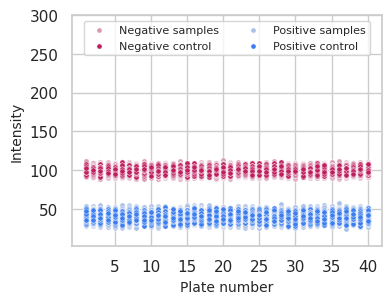

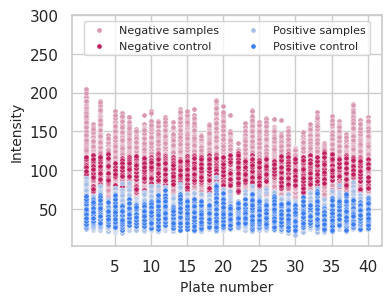

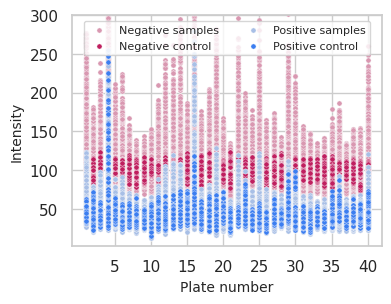

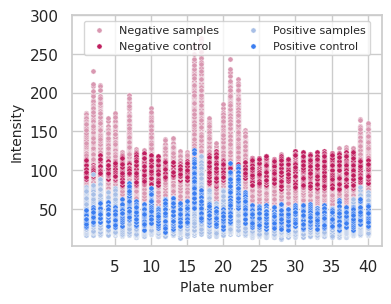

In [35]:
#residuals_filename = 'screening-residuals-10-20-0.05-20220323-test.csv'
#residuals_filename = 'screening-residuals-10-10-0.05-20220324-10-10-pl.csv'
#residuals_filename = 'screening-residuals-10-10-0.055-20220428-mean-40.csv'
#residuals_filename = 'screening-residuals-10-10-0.075-20220428-mean-36.csv'
residuals_filename = 'screening-residuals-10-20-0.075-20220428-mean-40.csv'
residuals_filename = 'screening-residuals-10-20-0.1-20220428-mean-36.csv'
residuals_filename = 'screening-residuals-10-10-0.1-20220428-mean-36.csv'
#residuals_filename = 'screening-residuals-10-10--0.01-20220428-mean-36.csv'
#residuals_filename = 'screening-residuals-10-10--0.025-20220428-mean-36.csv'
#residuals_filename = 'screening-residuals-10-10--0.075-20220428-mean-36.csv'#mm
#residuals_filename = 'screening-residuals-10-10--0.05-20220428-mean-36.csv' 
#residuals_filename = 'screening-residuals-10-10-0.055-20220429-mean-36.csv'

## 8-8
residuals_filename = 'screening-residuals-8-8-0.1-pna-0.99-20220920-paper-ROC.csv'
residuals_filename = 'screening-residuals-8-8-0.1-20220504-pna-0.9.csv'
residuals_filename = 'screening-residuals-8-8-0.1-20220503-pna-0.8.csv'
residuals_filename = 'screening-residuals-8-8-0.1-20220503-pna-0.7.csv'
residuals_filename = 'screening-residuals-8-8-0.1-pna-0.6-20220506-.csv'


## 10-10
residuals_filename = 'screening-residuals-10-10-0.1-20220429-pna-0.9.csv'
residuals_filename = 'screening-residuals-10-10-0.1-20220429-pna-0.8.csv'
#residuals_filename = 'screening-residuals-10-10-0.075-20220429-pna-0.8.csv'
residuals_filename = 'screening-residuals-10-10-0.1-20220429-pna-0.7.csv'
residuals_filename = 'screening-residuals-10-10-0.1-pna-0.6-20220506-.csv'

#residuals_filename = 'screening-residuals-8-8-0.085-20220503-pna-0.8.csv'

#residuals_filename = 'screening-residuals-8-8-0.05-20220503-pna-0.8.csv'


#residuals_filename = 'screening-residuals-8-8-0.05-20220503-pna-0.7.csv'

residuals_filename = 'screening-residuals-10-10-0.15-pna-0.9-20220506-.csv'
residuals_filename = 'screening-residuals-10-10-0.15-pna-0.6-20220506-.csv'

residuals_filename = 'screening-residuals-10-10-0.2-pna-0.6-20220506-.csv'

residuals_filename = 'screening-residuals-8-8-0.2-pna-0.9-20220506-.csv'

residuals_filename = 'screening-residuals-10-10-0.2-pna-0.9-20220506-.csv'
residuals_filename = 'screening-residuals-10-10-0.2-pna-0.8-20220506-.csv'

residuals_filename = 'screening-residuals-10-10--0.075-pna-0.8-20220506-.csv'

residuals_filename = 'screening-residuals-10-10-0.2-pna-0.7-20220506-.csv'
residuals_filename = 'screening-residuals-10-10-0.2-pna-0.99-20220509-.csv'
residuals_filename = 'screening-residuals-10-10-0.2-pna-0.995-20220509-.csv'
residuals_filename = 'screening-residuals-10-10-0.2-pna-0.95-20220509-.csv'
residuals_filename = 'screening-residuals-8-8-0.2-pna-0.99-20220509-.csv'
residuals_filename = 'screening-residuals-8-8-0.2-pna-0.95-20220509-.csv'

residuals_filename = 'screening-residuals-8-8-0.2-pna-0.95-20220509-multiple-batches.csv'

residuals_filename = 'screening-residuals-10-10-0.2-pna-0.99-20220509-multiple-batches.csv'

#residuals_filename = 'screening-residuals-10-10-0.2-pna-0.95-20220510-multiple-batches.csv'
#residuals_filename = 'screening-residuals-10-10-0.2-pna-0.9-20220510-multiple-batches.csv'
#residuals_filename = 'screening-residuals-10-10-0.2-pna-0.6-20220510-multiple-batches.csv'

#residuals_filename = 'screening-residuals-10-10-0.2-pna-0.99-20220509-.csv'



#residuals_filename = 'screening-residuals-10-20-0.065-pna-0.99-20220914-paper-figure.csv'
residuals_filename = 'screening-residuals-10-10-0.055-pna-0.99-20220914-paper-figure.csv'


residuals_filename = 'screening-residuals-8-8-0.1-pna-0.95-20220920-paper-ROC.csv'

residuals_filename = 'screening-residuals-10-10-0.2-pna-0.99-20220928-stdev-3.csv'


residuals_filename = 'screening-residuals-10-10-0.06-pna-0.99-20221102-stdev-3-4.csv'

residuals_filename = 'screening-residuals-10-10-0.08-pna-0.99-20221014-stdev-3-4.csv'

#residuals_filename = 'screening-residuals-10-10--0.04-pna-0.99-20221019-stdev-3-4.csv'

#residuals_filename = 'screening-residuals-10-10-0.04-pna-0.99-20221019-stdev-3-4.csv'

#NICE curves
residuals_filename = 'screening-residuals-10-10-0.15-pna-0.6-20221108-stdev-3-4.csv'

residuals_filename = 'screening-residuals-10-10-0.08-pna-0.6-20221108-stdev-3-4.csv'

fig_data = "0.08-10-10-0.99-stdev-3-4"
fig_data = "0.06-10-10-0.99-stdev-3-4"
save_plots = False

screening_residuals_df = pd.read_csv(residuals_filename)

screening_residuals_df = screening_residuals_df[screening_residuals_df.lost_rows<1]

screening_residuals_df.loc[(screening_residuals_df['layout'] == "RANDOM"), 'layout'] = "Random"
screening_residuals_df.loc[(screening_residuals_df['layout'] == "BORDER"), 'layout'] = "Border"
screening_residuals_df.loc[(screening_residuals_df['layout'] == "PLAID"), 'layout'] = "Effective"

neg_control_id = np.max(screening_residuals_df.comp_id)
pos_control_id = neg_control_id -1 
    
sns.set_theme(style="whitegrid")

max_value = max(screening_residuals_df.obtained_result)+45
max_value = 300
min_value = min(screening_residuals_df.obtained_result)-10

fig, ax = plt.subplots(figsize=(4, 3))
ax.set(ylim=(min_value,max_value))
#plt.yscale('log', base=2)

#'expected_result','obtained_result'
ax = sns.scatterplot(x="plate_id", y="expected_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.activity <1)], color='#d998b1', s=14)
ax = sns.scatterplot(x="plate_id", y="expected_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.comp_id==neg_control_id)],color='#bf1f5f', s=14)
ax = sns.scatterplot(x="plate_id", y="expected_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.activity > 0) & (screening_residuals_df.comp_id<pos_control_id)],color='#a8bfe6', s=14)
ax = sns.scatterplot(x="plate_id", y="expected_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.comp_id==pos_control_id)], color='#3c7ef0', s=14)
plt.xlabel('Plate number', fontsize = 10)
plt.ylabel('Intensity', fontsize = 10)
plt.xticks([i for i in range(5,41,5)])
plt.legend(labels=['Negative samples','Negative control','Positive samples','Positive control'],ncol=2, loc="upper center", fontsize = 8)
plt.show()

if save_plots:
    fig.savefig("screening-bowl-"+fig_data+"-expected.png",bbox_inches='tight',dpi=1200)

fig, ax = plt.subplots(figsize=(4, 3))
ax.set(ylim=(min_value,max_value))
#plt.yscale('log', base=2)

ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.activity <1)], color='#d998b1', s=14)
ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.comp_id==neg_control_id)],color='#bf1f5f', s=14)
ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.activity > 0) & (screening_residuals_df.comp_id<pos_control_id)],color='#a8bfe6', s=14)
ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.comp_id==pos_control_id)], color='#3c7ef0', s=14)
plt.xlabel('Plate number', fontsize = 10)
plt.ylabel('Intensity', fontsize = 10)
plt.xticks([i for i in range(5,41,5)])
plt.legend(labels=['Negative samples','Negative control','Positive samples','Positive control'],ncol=2, loc="upper center", fontsize = 8)
plt.show()

if save_plots:
    fig.savefig("screening-bowl-"+fig_data+"-plaid.png",bbox_inches='tight',dpi=1200)


fig, ax = plt.subplots(figsize=(4,3))
ax.set(ylim=(min_value,max_value))
#plt.yscale('log', base=2)

ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Random') & (screening_residuals_df.activity <1)], color='#d998b1', s=14)
ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Random') & (screening_residuals_df.comp_id==neg_control_id)],color='#bf1f5f', s=14)
ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Random') & (screening_residuals_df.activity > 0) & (screening_residuals_df.comp_id<pos_control_id)],color='#a8bfe6', s=14)
ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Random') & (screening_residuals_df.comp_id==pos_control_id)], color='#3c7ef0', s=14)
plt.xlabel('Plate number', fontsize = 10)
plt.ylabel('Intensity', fontsize = 10)
plt.xticks([i for i in range(5,41,5)])
plt.legend(labels=['Negative samples','Negative control','Positive samples','Positive control'],ncol=2, loc="upper center", fontsize = 8)
plt.show()

if save_plots:
    fig.savefig("screening-bowl-"+fig_data+"-random.png",bbox_inches='tight',dpi=1200)


fig, ax = plt.subplots(figsize=(4, 3))
ax.set(ylim=(min_value,max_value))

ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Border') & (screening_residuals_df.activity <1)], color='#d998b1', s=14)
ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Border') & (screening_residuals_df.comp_id==neg_control_id)],color='#bf1f5f', s=14)
ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Border') & (screening_residuals_df.activity > 0) & (screening_residuals_df.comp_id<pos_control_id)],color='#a8bfe6', s=14)
ax = sns.scatterplot(x="plate_id", y="obtained_result", data=screening_residuals_df.loc[(screening_residuals_df.layout=='Border') & (screening_residuals_df.comp_id==pos_control_id)], color='#3c7ef0', s=14)
plt.xlabel('Plate number', fontsize = 10)
plt.ylabel('Intensity', fontsize = 10)
plt.xticks([i for i in range(5,41,5)])
plt.legend(labels=['Negative samples','Negative control','Positive samples','Positive control'],ncol=2, loc="upper center", fontsize = 8)
plt.show()

if save_plots:
    fig.savefig("screening-bowl-"+fig_data+"-border.png",bbox_inches='tight',dpi=1200)


In [ ]:
# MAMI

# Supplement...

In [2]:
fig_dir = 'generated-plots/screening-supplement/'
data_dir = 'generated-data/'

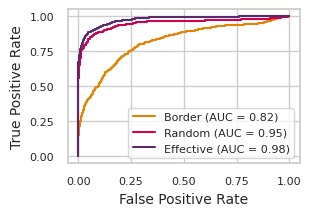

In [111]:
# In the manuscript (Figure 36f)
residuals_filename = data_dir+'screening-residuals-10-10-0.2-pna-0.99-20220509-multiple-batches.csv'

fig_name = 'ROC-10-10-0.2-1.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir, batch=6)

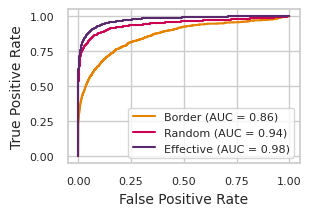

In [112]:
# In the manuscript (Figure 3g)
residuals_filename = data_dir+'screening-residuals-10-10-0.2-pna-0.95-20220510-multiple-batches.csv'

fig_name = 'ROC-10-10-0.2-5.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir, batch=9)

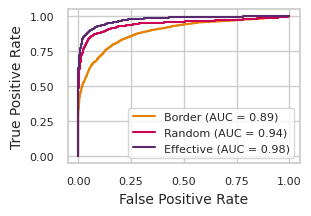

In [139]:
# In the supplement, Figure 23a
residuals_filename = data_dir+'screening-residuals-10-10-0.2-pna-0.9-20220510-multiple-batches.csv'

fig_name = 'ROC-10-10-0.2-10.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir, batch=0)

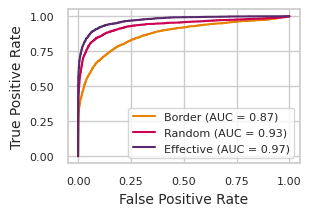

In [160]:
# In the supplement, Figure 23b
residuals_filename = data_dir+'screening-residuals-10-10-0.2-pna-0.8-20221122-ROC-supplement.csv'

fig_name = 'ROC-10-10-0.2-20.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir, batch=2)

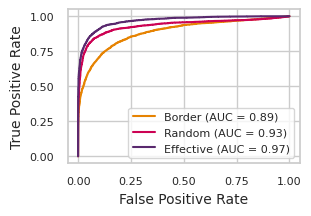

In [159]:
# In the supplement, Figure 23c 
residuals_filename = data_dir+'screening-residuals-10-10-0.2-pna-0.7-20221122-ROC-supplement.csv'

fig_name = 'ROC-10-10-0.2-30.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir,batch=6)

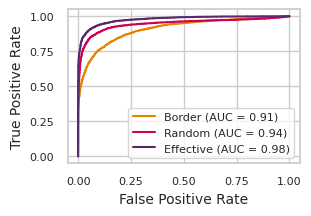

In [133]:
# In the supplement, Figure 23d
residuals_filename = data_dir+'screening-residuals-10-10-0.2-pna-0.6-20220510-multiple-batches.csv'

fig_name = 'ROC-10-10-0.2-40.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir)

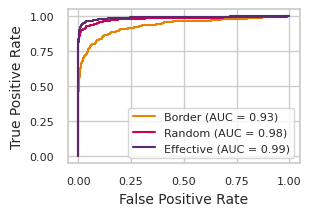

In [177]:
# In the supplement, Figure 24a 
residuals_filename = data_dir+'screening-residuals-8-8-0.1-pna-0.99-20220920-paper-ROC.csv'

fig_name = 'ROC-8-8-0.1-1.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir)

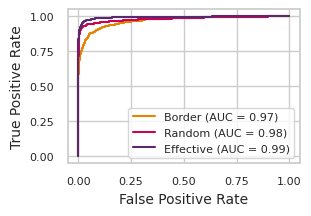

In [162]:
# In the supplement, Figure 24b 
residuals_filename = data_dir+'screening-residuals-8-8-0.1-pna-0.95-20220920-paper-ROC.csv'

fig_name = 'ROC-8-8-0.1-5.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir, batch=1)

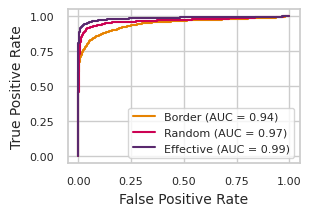

In [197]:
# In the supplement, Figure 24c 
residuals_filename = data_dir+'screening-residuals-8-8-0.1-pna-0.9-20221122-ROC-supplement.csv'

fig_name = 'ROC-8-8-0.1-10.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir, batch=6)

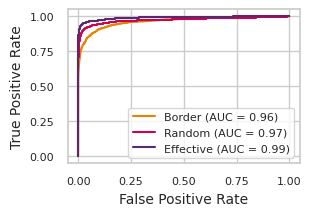

In [215]:
# In the supplement, Figure 24d 
residuals_filename = data_dir+'screening-residuals-8-8-0.1-pna-0.8-20221122-ROC-supplement.csv'

fig_name = 'ROC-8-8-0.1-20.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir, batch=6)

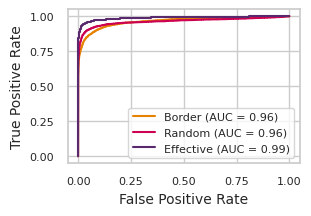

In [234]:
# In the supplement, Figure 24e 
residuals_filename = data_dir+'screening-residuals-8-8-0.1-pna-0.7-20221122-ROC-supplement.csv'

fig_name = 'ROC-8-8-0.1-30.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir, batch=6)

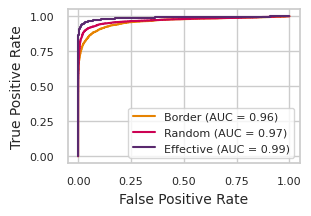

In [246]:
# In the supplement, Figure 24f
residuals_filename = data_dir+'screening-residuals-8-8-0.1-pna-0.6-20221122-ROC-supplement.csv'

fig_name = 'ROC-8-8-0.1-40.png'

plot_roc_curves(residuals_filename, fig_name, fig_dir, batch=3)

In [79]:
def plot_roc_curves(residuals_filename, fig_name=None, fig_dir='', batch=0, batches=10):

    screening_residuals_df = pd.read_csv(residuals_filename)

    screening_residuals_df = screening_residuals_df[screening_residuals_df.lost_rows<1]

    screening_residuals_df.loc[(screening_residuals_df['layout'] == "RANDOM"), 'layout'] = "Random"
    screening_residuals_df.loc[(screening_residuals_df['layout'] == "BORDER"), 'layout'] = "Border"
    screening_residuals_df.loc[(screening_residuals_df['layout'] == "PLAID"), 'layout'] = "Effective"

    screening_residuals_df['obtained_result_inv'] = -screening_residuals_df.obtained_result

    colors = ['#59296e','#cc0253','#e68302']

    results_plaid = screening_residuals_df[(screening_residuals_df.layout=='Effective') ]
    results_random = screening_residuals_df[(screening_residuals_df.layout=='Random') ]
    results_border = screening_residuals_df[(screening_residuals_df.layout=='Border') ]


    fig, ax = plt.subplots(figsize=(3, 2))


    ## Border
    fpr, tpr, thresholds = metrics.roc_curve(results_border.loc[results_border.batch==batch,'activity'],  results_border.loc[results_border.batch==batch,'obtained_result_inv'])
    auc_border = metrics.roc_auc_score(results_border.loc[results_border.batch==batch,'activity'],  results_border.loc[results_border.batch==batch,'obtained_result_inv'])

    #create ROC curve
    plt.plot(fpr,tpr,color=colors[2])


    ## Random
    fpr, tpr, thresholds = metrics.roc_curve(results_random.loc[results_random.batch==batch,'activity'],  results_random.loc[results_random.batch==batch,'obtained_result_inv'])
    auc_random = metrics.roc_auc_score(results_random.loc[results_random.batch==batch,'activity'],  results_random.loc[results_random.batch==batch,'obtained_result_inv'])

    #create ROC curve
    plt.plot(fpr,tpr,color=colors[1])


    ## PLAID
    fpr, tpr, thresholds = metrics.roc_curve(results_plaid.loc[results_plaid.batch==batch,'activity'],  results_plaid.loc[results_plaid.batch==batch,'obtained_result_inv'])
    auc_plaid = metrics.roc_auc_score(results_plaid.loc[results_plaid.batch==batch,'activity'],  results_plaid.loc[results_plaid.batch==batch,'obtained_result_inv'])
    auc_plaid_str = '{0:.2g}'.format(auc_plaid)

    #create ROC curve
    plt.plot(fpr,tpr,color=colors[0])

    plt.ylabel('True Positive Rate', fontsize = 10)
    plt.xlabel('False Positive Rate', fontsize = 10)
    plt.legend(labels=['Border (AUC = '+str(round(auc_border,2))+')','Random (AUC = '+str(round(auc_random,2))+')','Effective (AUC = '+auc_plaid_str+')'],loc='lower right', fontsize = 8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

    if fig_name:
        fig.savefig(fig_dir+fig_name,bbox_inches='tight',dpi=300)
    
def temp_table_code(screening_residuals_df):
    plaid_auc_list = [metrics.roc_auc_score(results_plaid.loc[results_plaid.batch==b,'activity'],  results_plaid.loc[results_plaid.batch==b,'obtained_result_inv']) for b in range(batches)]
    random_auc_list = [metrics.roc_auc_score(results_random.loc[results_random.batch==b,'activity'],  results_random.loc[results_random.batch==b,'obtained_result_inv']) for b in range(batches)]
    border_auc_list = [metrics.roc_auc_score(results_border.loc[results_border.batch==b,'activity'],  results_border.loc[results_border.batch==b,'obtained_result_inv']) for b in range(batches)]

    print("Mean and std of PLAID layouts:", round(statistics.mean(plaid_auc_list),2)," $\\pm$ ("+str(round(statistics.stdev(plaid_auc_list),3))+")")
    print("Mean and std of RANDOM layouts:", round(statistics.mean(random_auc_list),2)," $\\pm$ ("+str(round(statistics.stdev(random_auc_list),3))+")")
    print("Mean and std of BORDER layouts:", round(statistics.mean(border_auc_list),2)," $\\pm$ ("+str(round(statistics.stdev(border_auc_list),3))+")\n")


    print("Variance of PLAID layouts:", statistics.variance(plaid_auc_list))
    print("Variance of RANDOM layouts:", statistics.variance(random_auc_list))
    print("Variance of BORDER layouts:", statistics.variance(border_auc_list),"\n")


    print("Case of equal variance:")
    print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_auc_list,random_auc_list,equal_var = True))
    print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_auc_list,random_auc_list,equal_var = True))
    print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_auc_list,border_auc_list,equal_var = True),"\n")

    print("Case of not equal variance:")
    print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_auc_list,random_auc_list,equal_var = False))
    print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_auc_list,random_auc_list,equal_var = False))
    print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_auc_list,border_auc_list,equal_var = False))

In [74]:
def plot_roc_curves2(residuals_filename, fig_name='', fig_dir='', batch=0, batches=10):

    screening_residuals_df = pd.read_csv(residuals_filename)

    screening_residuals_df = screening_residuals_df[screening_residuals_df.lost_rows<1]

    screening_residuals_df.loc[(screening_residuals_df['layout'] == "RANDOM"), 'layout'] = "Random"
    screening_residuals_df.loc[(screening_residuals_df['layout'] == "BORDER"), 'layout'] = "Border"
    screening_residuals_df.loc[(screening_residuals_df['layout'] == "PLAID"), 'layout'] = "Effective"

    screening_residuals_df['obtained_result_inv'] = -screening_residuals_df.obtained_result

    colors = ['#59296e','#cc0253','#e68302']

    results_plaid = screening_residuals_df[(screening_residuals_df.layout=='Effective') ]
    results_random = screening_residuals_df[(screening_residuals_df.layout=='Random') ]
    results_border = screening_residuals_df[(screening_residuals_df.layout=='Border') ]


    fig, ax = plt.subplots(figsize=(3, 2))


    ## Border
    fpr, tpr, thresholds = metrics.roc_curve(results_border['activity'],  results_border['obtained_result_inv'])
    auc_border = metrics.roc_auc_score(results_border['activity'],  results_border['obtained_result_inv'])

    #create ROC curve
    plt.plot(fpr,tpr,color=colors[2])


    ## Random
    fpr, tpr, thresholds = metrics.roc_curve(results_random.loc['activity'],  results_random.loc['obtained_result_inv'])
    auc_random = metrics.roc_auc_score(results_random.loc['activity'],  results_random.loc['obtained_result_inv'])

    #create ROC curve
    plt.plot(fpr,tpr,color=colors[1])


    ## PLAID
    fpr, tpr, thresholds = metrics.roc_curve(results_plaid.loc['activity'],  results_plaid.loc['obtained_result_inv'])
    auc_plaid = metrics.roc_auc_score(results_plaid.loc['activity'],  results_plaid.loc['obtained_result_inv'])
    auc_plaid_str = '{0:.3g}'.format(auc_plaid)

    #create ROC curve
    plt.plot(fpr,tpr,color=colors[0])

    plt.ylabel('True Positive Rate', fontsize = 10)
    plt.xlabel('False Positive Rate', fontsize = 10)
    plt.legend(labels=['Border (AUC = '+str(round(auc_border,3))+')','Random (AUC = '+str(round(auc_random,3))+')','Effective (AUC = '+auc_plaid_str+')'],loc='lower right', fontsize = 8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

In [ ]:
fig.savefig(fig_dir+"ROC-10-10-0.15-40.png",bbox_inches='tight',dpi=300)

In [ ]:
## OLD

from sklearn import metrics

percent_non_active = 0.99

screening_residuals_df['y_test'] = 0
screening_residuals_df.loc[(screening_residuals_df.comp_id > percent_non_active*(neg_control_id-2)) & (screening_residuals_df.comp_id<pos_control_id), 'y_test'] = 1
#screening_residuals_df.loc[(screening_residuals_df.comp_id > 2*(neg_control_id-2)//3) & (screening_residuals_df.comp_id<pos_control_id), 'y_test'] = 1
#screening_residuals_df.loc[(screening_residuals_df.comp_id < 2*(neg_control_id-2)//3), 'y_test'] = 0
screening_residuals_df['obtained_result_inv'] = -screening_residuals_df.obtained_result

colors = ['#59296e','#cc0253','#e68302']


#            if (layout[row_index][col_index] == neg_control_id) or (layout[row_index][col_index] <= percent_non_active*(neg_control_id-2)):
 #                plate[row_index][col_index] = np.random.normal(neg_control_mean, neg_stdev)
  #          else:
   #              plate[row_index][col_index] = np.random.normal(pos_control_mean, pos_stdev)

                    
                    
#print(screening_residuals_df.loc[(screening_residuals_df.comp_id > 2*(neg_control_id-2)//3) & (screening_residuals_df.comp_id<pos_control_id), 'obtained_result'])
#screening_residuals_df.loc[(screening_residuals_df.comp_id <= 2*(neg_control_id-2)//3), 'y_test'] = 1                                                                            
#print(screening_residuals_df.obtained_result)

results_plaid = screening_residuals_df[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.comp_id<pos_control_id) ]
results_random = screening_residuals_df[(screening_residuals_df.layout=='Random') & (screening_residuals_df.comp_id<pos_control_id)]
results_border = screening_residuals_df[(screening_residuals_df.layout=='Border') & (screening_residuals_df.comp_id<pos_control_id)]
#results_plaid.y_test = 0 
#screening_residuals_df.comp_id > 2*(neg_control_id-2)//3) & (screening_residuals_df.comp_id<pos_control_id


batch = 1

fpr, tpr, thresholds = metrics.roc_curve(results_plaid.y_test,  results_plaid.obtained_result_inv)

auc_plaid = metrics.roc_auc_score(results_plaid.y_test,  results_plaid.obtained_result_inv)
auc_plaid_str = '{0:.2g}'.format(auc_plaid)

#create ROC curve
fig, ax = plt.subplots(figsize=(3, 2))
plt.plot(fpr,tpr,color=colors[0])

fpr, tpr, _ = metrics.roc_curve(results_random.y_test,  results_random.obtained_result_inv)

auc_random = metrics.roc_auc_score(results_random.y_test,  results_random.obtained_result_inv)

#create ROC curve
plt.plot(fpr,tpr,color=colors[1])

fpr, tpr, _ = metrics.roc_curve(results_border.y_test,  results_border.obtained_result_inv)

auc_border = metrics.roc_auc_score(results_border.y_test,  results_border.obtained_result_inv)

#create ROC curve
plt.plot(fpr,tpr,color=colors[2])

plt.ylabel('True Positive Rate', fontsize = 10)
plt.xlabel('False Positive Rate', fontsize = 10)
plt.legend(labels=['Effective (AUC = '+auc_plaid_str+')','Random (AUC = '+str(round(auc_random,2))+')','Border (AUC = '+str(round(auc_border,2))+')'],loc='lower right', fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

batches = 10
plaid_auc_list = [metrics.roc_auc_score(results_plaid.loc[results_plaid.batch==b,'activity'],  results_plaid.loc[results_plaid.batch==b,'obtained_result_inv']) for b in range(batches)]
random_auc_list = [metrics.roc_auc_score(results_random.loc[results_random.batch==b,'activity'],  results_random.loc[results_random.batch==b,'obtained_result_inv']) for b in range(batches)]
border_auc_list = [metrics.roc_auc_score(results_border.loc[results_border.batch==b,'activity'],  results_border.loc[results_border.batch==b,'obtained_result_inv']) for b in range(batches)]




print("Variance of PLAID layouts:", statistics.variance(plaid_auc_list))
print("Variance of RANDOM layouts:", statistics.variance(random_auc_list))
print("Variance of BORDER layouts:", statistics.variance(border_auc_list))

#print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_auc_list,random_auc_list))
print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_auc_list,random_auc_list,equal_var = True))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_auc_list,random_auc_list,equal_var = True))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_auc_list,border_auc_list,equal_var = True))

print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_auc_list,random_auc_list,equal_var = False))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_auc_list,random_auc_list,equal_var = False))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_auc_list,border_auc_list,equal_var = False))




In [ ]:
fig.savefig("ROC-10-10-0.2-1.png",bbox_inches='tight',dpi=300)

In [ ]:
from sklearn.metrics import confusion_matrix

screening_residuals_df['y_pred'] = 0
screening_residuals_df.loc[(screening_residuals_df.obtained_result <=66), 'y_pred'] = 1 

results_plaid = screening_residuals_df[(screening_residuals_df.layout=='Effective') & (screening_residuals_df.comp_id<pos_control_id) ] 

y_true = results_plaid.y_test
y_pred = results_plaid.y_pred
confusion_matrix(results_plaid.y_test, results_plaid.y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix

screening_residuals_df['y_pred'] = 0
screening_residuals_df.loc[(screening_residuals_df.obtained_result <=66), 'y_pred'] = 1 

results_random = screening_residuals_df[(screening_residuals_df.layout=='Random') & (screening_residuals_df.comp_id<pos_control_id) ] 

y_true = results_random.y_test
y_pred = results_random.y_pred
confusion_matrix(results_random.y_test, results_random.y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix

screening_residuals_df['y_pred'] = 0
screening_residuals_df.loc[(screening_residuals_df.obtained_result <=56), 'y_pred'] = 1 

results_border = screening_residuals_df[(screening_residuals_df.layout=='Border') & (screening_residuals_df.comp_id<pos_control_id) ] 

y_true = results_border.y_test
y_pred = results_border.y_pred
confusion_matrix(results_border.y_test, results_border.y_pred)

# Medium Error

In [ ]:
# Residuals

## Loading data
screening_residuals_df = pd.read_csv('screening-residuals-10-10-0.075-20210922.csv')

screening_residuals_df

In [ ]:
screening_residuals_df.loc[(screening_residuals_df['layout'] >= "plate_layout_rand"), 'layout'] = "RANDOM"
screening_residuals_df.loc[(screening_residuals_df['layout'] >= "plate_layout_border") & (screening_residuals_df['layout'] != "RANDOM"), 'layout'] = "BORDER"
screening_residuals_df.loc[(screening_residuals_df['layout'] >= "plate_layout") & (screening_residuals_df['layout'] != "RANDOM") & (screening_residuals_df['layout'] != "BORDER"), 'layout'] = "PLAID"


print(screening_residuals_df[screening_residuals_df['layout']=='PLAID'].describe())

print(screening_residuals_df[screening_residuals_df['layout']=='RANDOM'].describe())

print(screening_residuals_df[screening_residuals_df['layout']=='BORDER'].describe())


print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array))
print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 15))

#ax.set(ylim=(0,0.6))

ax = sns.barplot(x="layout", y="true_residuals", data=screening_residuals_df, order=["PLAID", "RANDOM", "BORDER"])

#ax = sns.barplot(x="layout", y="MSE", data=results_df[results_df['MSE']!=np.inf], order=["PLAID", "RANDOM"])

ax.set(xlabel='Layout type', ylabel='Residuals')

plt.show()


In [ ]:
# Rain plot
#temp_half = residuals_df#[(residuals_df['MSE']!=np.inf) & (residuals_df['rows lost']<=1) & (residuals_df['E']>20) & (residuals_df['E']<100) ]
#temp_half.loc[(temp_half['layout']=='PLAID') & (temp_half["MSE"]>0.688),"MSE"] = 0.1

fig, ax = plt.subplots(figsize=(15, 10))

#ax = sns.barplot(x="layout", y="MSE", data=temp_half, order=["PLAID", "RANDOM"])

#sns.barplot(x = "group", y = "score", data = df, capsize= .1)
pal = sns.color_palette(n_colors=1)

#ax=pt.half_violinplot( x = "MSE", y = "layout", data = temp_half, palette = pal, bw = .2, cut = 0.,
 #                     scale = "area", width = .6, inner = None, orient = ort, order=["PLAID", "RANDOM"])

dx = "true_residuals"; dy = "layout"; ort = "h"; pal = "Set2"; sigma = 0.01
#f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x = "layout", y = "true_residuals", data = screening_residuals_df, palette = pal, bw = sigma,
                 width_viol = 1.2, ax = ax, orient = ort, order=["PLAID", "RANDOM", "BORDER"], jitter = 0.15)

#ax = sns.violinplot(x="MSE", y="layout", data=temp_half, order=["PLAID", "RANDOM"])
#ax = sns.stripplot(x="MSE", y="layout", data=temp_half,morder=["PLAID", "RANDOM"], jitter=0.3)

ax.set(xlabel='Residuals', ylabel='Layout type')

plt.show()

In [ ]:
temp_none = screening_residuals_df[(screening_residuals_df['lost_rows']<=1) ]

rand_results_array = temp_none.true_residuals[temp_none.layout=="RANDOM"]
plaid_results_array = temp_none.true_residuals[temp_none.layout=="PLAID"]
border_results_array = temp_none.true_residuals[temp_none.layout=="BORDER"]

print("Variance of PLAID layouts:", statistics.variance(plaid_results_array))
print("Variance of RANDOM layouts:", statistics.variance(rand_results_array))
print("Variance of BORDER layouts:", statistics.variance(border_results_array))

print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array))
print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False))

In [ ]:
# Rain plot
#temp_half = residuals_df#[(residuals_df['MSE']!=np.inf) & (residuals_df['rows lost']<=1) & (residuals_df['E']>20) & (residuals_df['E']<100) ]
#temp_half.loc[(temp_half['layout']=='PLAID') & (temp_half["MSE"]>0.688),"MSE"] = 0.1

fig, ax = plt.subplots(figsize=(15, 10))

#ax = sns.barplot(x="layout", y="MSE", data=temp_half, order=["PLAID", "RANDOM"])

#sns.barplot(x = "group", y = "score", data = df, capsize= .1)
pal = sns.color_palette(n_colors=1)

#ax=pt.half_violinplot( x = "MSE", y = "layout", data = temp_half, palette = pal, bw = .2, cut = 0.,
 #                     scale = "area", width = .6, inner = None, orient = ort, order=["PLAID", "RANDOM"])

dx = "true_residuals"; dy = "layout"; ort = "h"; pal = "Set2"; sigma = 0.01
#f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x = "layout", y = "true_residuals", data = temp_none, palette = pal, bw = sigma,
                 width_viol = 1.2, ax = ax, orient = ort, order=["PLAID", "RANDOM", "BORDER"], jitter = 0.15)

#ax = sns.violinplot(x="MSE", y="layout", data=temp_half, order=["PLAID", "RANDOM"])
#ax = sns.stripplot(x="MSE", y="layout", data=temp_half,morder=["PLAID", "RANDOM"], jitter=0.3)

ax.set(xlabel='Residuals', ylabel='Layout type')

plt.show()

# High Error

In [ ]:
# Residuals

## Loading data
screening_residuals_high_error_df = pd.read_csv('screening-residuals-10-10-0.125-20210924.csv')

#screening_residuals_high_error_df.loc[(screening_residuals_high_error_df['layout'] >= "plate_layout_rand"), 'layout'] = "RANDOM"
#screening_residuals_high_error_df.loc[(screening_residuals_high_error_df['layout'] >= "plate_layout_border") & (screening_residuals_high_error_df['layout'] != "RANDOM"), 'layout'] = "BORDER"
#screening_residuals_high_error_df.loc[(screening_residuals_high_error_df['layout'] >= "plate_layout") & (screening_residuals_high_error_df['layout'] != "RANDOM") & (screening_residuals_high_error_df['layout'] != "BORDER"), 'layout'] = "PLAID"


print(screening_residuals_high_error_df[screening_residuals_high_error_df['layout']=='PLAID'].describe())

print(screening_residuals_high_error_df[screening_residuals_high_error_df['layout']=='RANDOM'].describe())

print(screening_residuals_high_error_df[screening_residuals_high_error_df['layout']=='BORDER'].describe())


rand_results_array = screening_residuals_high_error_df.true_residuals[screening_residuals_high_error_df.layout=="RANDOM"]
plaid_results_array = screening_residuals_high_error_df.true_residuals[screening_residuals_high_error_df.layout=="PLAID"]
border_results_array = screening_residuals_high_error_df.true_residuals[screening_residuals_high_error_df.layout=="BORDER"]

print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array))
print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 15))

#ax.set(ylim=(0,0.6))

ax = sns.barplot(x="layout", y="true_residuals", data=screening_residuals_high_error_df, order=["PLAID", "RANDOM", "BORDER"])

#ax = sns.barplot(x="layout", y="MSE", data=results_df[results_df['MSE']!=np.inf], order=["PLAID", "RANDOM"])

ax.set(xlabel='Layout type', ylabel='Residuals')

plt.show()


In [ ]:
# Rain plot
#temp_half = residuals_df#[(residuals_df['MSE']!=np.inf) & (residuals_df['rows lost']<=1) & (residuals_df['E']>20) & (residuals_df['E']<100) ]
#temp_half.loc[(temp_half['layout']=='PLAID') & (temp_half["MSE"]>0.688),"MSE"] = 0.1

fig, ax = plt.subplots(figsize=(15, 10))

#ax = sns.barplot(x="layout", y="MSE", data=temp_half, order=["PLAID", "RANDOM"])

#sns.barplot(x = "group", y = "score", data = df, capsize= .1)
pal = sns.color_palette(n_colors=1)

#ax=pt.half_violinplot( x = "MSE", y = "layout", data = temp_half, palette = pal, bw = .2, cut = 0.,
 #                     scale = "area", width = .6, inner = None, orient = ort, order=["PLAID", "RANDOM"])

dx = "true_residuals"; dy = "layout"; ort = "h"; pal = "Set2"; sigma = 0.01
#f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x = "layout", y = "true_residuals", data = screening_residuals_high_error_df, palette = pal, bw = sigma,
                 width_viol = 1.2, ax = ax, orient = ort, order=["PLAID", "RANDOM", "BORDER"], jitter = 0.15)

#ax = sns.violinplot(x="MSE", y="layout", data=temp_half, order=["PLAID", "RANDOM"])
#ax = sns.stripplot(x="MSE", y="layout", data=temp_half,morder=["PLAID", "RANDOM"], jitter=0.3)

ax.set(xlabel='Residuals', ylabel='Layout type')

plt.show()

In [ ]:
rand_results_array = temp_half.MSE[temp_half.layout=="RANDOM"]
plaid_results_array = temp_half.MSE[temp_half.layout=="PLAID"]
border_results_array = temp_half.MSE[temp_half.layout=="BORDER"]

print("Variance of PLAID layouts:", statistics.variance(plaid_results_array))
print("Variance of RANDOM layouts:", statistics.variance(rand_results_array))
print("Variance of BORDER layouts:", statistics.variance(border_results_array))

print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array))
print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))

print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))

print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False))

## Evaluating Residuals

We first look at the residuals against the fitted sigmoid

In [ ]:
# 1 replicate
#residuals = np.loadtxt('residuals-48-6-1-20210630.csv', delimiter=',', dtype='str')

# 2 replicates
#residuals = np.loadtxt('residuals-20210621.csv', delimiter=',', dtype='str')

# 3 replicates
residuals = np.loadtxt('residuals-16-6-3complete-20210716.csv', delimiter=',', dtype='str')


In [ ]:
residuals_df = pd.DataFrame(residuals, columns=["layout", "error_type", "Error", "E", "rows lost", "residuals", "true_residuals"])
residuals_df.residuals = pd.to_numeric(residuals_df.residuals, errors='coerce')
residuals_df.true_residuals = pd.to_numeric(residuals_df.true_residuals, errors='coerce')

results_df = results_df[(results_df['rows lost']<=1) ]

#residuals_df = residuals_df[np.logical_not(np.isnan(residuals_df["residuals"]))]

#residuals_df = residuals_df.sort_values("residuals")

## Rename the layouts so they can be grouped as PLAID, RANDOM or Border
residuals_df.loc[(residuals_df['layout'] >= "plate_layout_rand"), 'layout'] = "RANDOM"
residuals_df.loc[(residuals_df['layout'] >= "plate_layout_border") & (residuals_df['layout'] != "RANDOM"), 'layout'] = "BORDER"
residuals_df.loc[(residuals_df['layout'] >= "plate_layout") & (residuals_df['layout'] != "RANDOM"), 'layout'] = "PLAID"

print(residuals_df)

#res_data = np.empty((0,2))
#for layout in ['PLAID','RANDOM','BORDER']:
#    layout_res = np.concatenate(np.array(residuals_df[residuals_df['layout']==layout]['residuals']))
#    res = np.vstack([np.full(len(layout_res),layout),layout_res]).T
#    res_data = np.vstack([res_data,res])

#res_df = pd.DataFrame(res_data, columns=["layout", "SE"])
#res_df.SE = pd.to_numeric(res_df.SE, errors='coerce')
#res_df = res_df.sort_values("SE")

residuals_df.residuals = pd.to_numeric(residuals_df.residuals, errors='coerce')
residuals_df = residuals_df.sort_values("residuals")

print("PLAID:\n",residuals_df[residuals_df['layout']=='PLAID'].describe(),"\n")

print("RANDOM:\n",residuals_df[residuals_df['layout']=='RANDOM'].describe(),"\n")

print("BORDER:\n",residuals_df[residuals_df['layout']=='BORDER'].describe(),"\n")

fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.barplot(x="layout", y="true_residuals", data=residuals_df, order=["PLAID", "RANDOM", "BORDER"])


In [ ]:
# Rain plot
temp_half = residuals_df#[(residuals_df['MSE']!=np.inf) & (residuals_df['rows lost']<=1) & (residuals_df['E']>20) & (residuals_df['E']<100) ]
#temp_half.loc[(temp_half['layout']=='PLAID') & (temp_half["MSE"]>0.688),"MSE"] = 0.1

fig, ax = plt.subplots(figsize=(15, 10))

#ax = sns.barplot(x="layout", y="MSE", data=temp_half, order=["PLAID", "RANDOM"])

#sns.barplot(x = "group", y = "score", data = df, capsize= .1)
pal = sns.color_palette(n_colors=1)

#ax=pt.half_violinplot( x = "MSE", y = "layout", data = temp_half, palette = pal, bw = .2, cut = 0.,
 #                     scale = "area", width = .6, inner = None, orient = ort, order=["PLAID", "RANDOM"])

dx = "MSE"; dy = "layout"; ort = "h"; pal = "Set2"; sigma = 0.01
#f, ax = plt.subplots(figsize=(7, 5))

ax = pt.RainCloud(x = "layout", y = "residuals", data = temp_half, palette = pal, bw = sigma,
                 width_viol = 1.2, ax = ax, orient = ort, order=["PLAID", "RANDOM", "BORDER"], jitter = 0.15)

#ax = sns.violinplot(x="MSE", y="layout", data=temp_half, order=["PLAID", "RANDOM"])
#ax = sns.stripplot(x="MSE", y="layout", data=temp_half,morder=["PLAID", "RANDOM"], jitter=0.3)

ax.set(xlabel='Residuals', ylabel='Layout type')

plt.show()

In [ ]:
fig.savefig("raincloud-dose-response-true-residuals-plaid-rand-border-20210621-36-4-2_0.125_0.25.png")

In [ ]:
rand_results_array = true_res_df.SE[true_res_df.layout=="RANDOM"]
plaid_results_array = true_res_df.SE[true_res_df.layout=="PLAID"]
border_results_array = true_res_df.SE[true_res_df.layout=="BORDER"]

print("Variance of PLAID layouts:", statistics.variance(plaid_results_array))
print("Variance of RANDOM layouts:", statistics.variance(rand_results_array))
print("Variance of BORDER layouts:", statistics.variance(border_results_array),"\n")

print("PLAID vs RANDOM layouts:", stats.ttest_ind(plaid_results_array,rand_results_array,equal_var = False))
print("RANDOM vs BORDER layouts:", stats.ttest_ind(border_results_array,rand_results_array,equal_var = False))
print("PLAID vs BORDER layouts:", stats.ttest_ind(plaid_results_array,border_results_array,equal_var = False))

## References

[1] Zhang, X.D., 2008. Novel analytic criteria and effective plate designs for quality control in genome-scale RNAi screens. _Journal of biomolecular screening_, 13(5), pp.363-377.

$\LaTeX$

In [ ]:
# Example of how to create a random layout
for i in range(21,41,1):
    #util.create_random_layout_screening(str(i), neg_controls=8, pos_controls = 8,directory="layouts/screening_manual_layouts")

In [ ]:
compounds_layout = np.load('compounds_manual_layouts/plate_layout_border_01.npy').astype(np.float32)

print(compounds_layout) 


In [ ]:
test_layout = np.load('screening_manual_layouts/'+'plate_layout_border_20-10_01.npy').astype(np.float32)

print(test_layout)

In [ ]:
## Temp code used to create manual layouts

control_locations = np.full((16, 24), 0)


#Left
control_locations[1][1] = 2
control_locations[2][1] = 2
control_locations[3][1] = 1

control_locations[4][1] = 1
#control_locations[5][1] = 2

#control_locations[6][1] = 1
#control_locations[7][1] = 1

#control_locations[8][1] = 1
#control_locations[9][1] = 1

#control_locations[10][1] = 1
control_locations[11][1] = 1

control_locations[12][1] = 1
control_locations[13][1] = 2
control_locations[14][1] = 2


## Right
#

#
control_locations[1][22] = 2
control_locations[2][22] = 2
control_locations[3][22] = 1

control_locations[4][22] = 1
#control_locations[5][22] = 2

#control_locations[6][22] = 2
#control_locations[7][22] = 2

#control_locations[8][22] = 1
#control_locations[9][22] = 1

#control_locations[10][22] = 1
control_locations[11][22] = 1

control_locations[12][22] = 1

control_locations[13][22] = 2
control_locations[14][22] = 2


#


util.fill_in_border_layout_screening_vertically('41', control_locations, directory="layouts/screening_manual_layouts", size_empty_edge=1)


In [ ]:

#layout_dir = 'layouts/screening_PLAID_layouts/'
layout_dir = 'layouts/screening_manual_layouts/'

util.check_duplicated_layouts(layout_dir)

In [ ]:

import fnmatch
count_layouts = os.listdir("layouts/screening_PLAID_layouts")
print(len(fnmatch.filter(count_layouts,'plate_*')))

In [ ]:
layout_array = [249, 151, 293, 235, 197, 241, 244, 14, 252, 264, 15, 139, 66, 223, 17, 51, 130, 257, 90, 129, 243, 157, 12, 40, 149, 68, 53, 267, 62, 126, 67, 214, 294, 79, 268, 31, 239, 185, 203, 21, 136, 266, 263, 255, 55, 198, 195, 114, 33, 37, 131, 162, 97, 228, 63, 39, 83, 205, 92, 88, 138, 161, 87, 293, 155, 70, 45, 80, 103, 24, 127, 108, 125, 124, 152, 41, 188, 210, 1, 57, 177, 2, 294, 200, 133, 206, 199, 93, 179, 81, 102, 293, 237, 172, 219, 56, 111, 191, 96, 142, 208, 13, 190, 221, 225, 163, 176, 145, 77, 65, 64, 76, 30, 58, 134, 117, 73, 91, 217, 189, 158, 234, 173, 74, 182, 178, 98, 82, 113, 38, 175, 294, 218, 72, 290, 122, 150, 292, 294, 52, 288, 291, 277, 293, 253, 169, 233, 89, 275, 261, 231, 227, 71, 140, 128, 282, 196, 105, 9, 220, 194, 26, 272, 242, 156, 280, 240, 232, 43, 294, 119, 20, 146, 281, 144, 278, 101, 48, 109, 60, 154, 166, 213, 110, 16, 106, 211, 165, 25, 32, 170, 212, 118, 159, 209, 183, 293, 36, 153, 35, 186, 95, 6, 294, 260, 201, 86, 181, 238, 19, 184, 265, 274, 121, 135, 259, 120, 61, 202, 50, 75, 7, 160, 258, 226, 84, 147, 11, 254, 246, 256, 23, 262, 215, 294, 276, 148, 286, 174, 54, 34, 18, 294, 224, 230, 69, 270, 3, 193, 289, 287, 94, 283, 104, 85, 284, 4, 285, 245, 293, 99, 141, 273, 5, 247, 250, 167, 107, 293, 271, 137, 42, 123, 279, 8, 115, 171, 164, 29, 204, 251, 22, 207, 132, 46, 222, 248, 49, 187, 192, 180, 100, 112, 293, 59, 236, 116, 78, 143, 47, 44, 168, 216, 28, 10, 229, 269, 27]
util.save_plaid_screening_layout("40", layout_array, num_rows=16, num_columns=24, size_empty_edge=1, directory="layouts/screening_PLAID_layouts")

